# _ARIEL_

# Table of Contents

0. [Import and installation requirements](#section0)
1. [Asserting that the model is coherent](#section1)
2. [Drawing simple geometric figures](#section2)
3. [Drawing simplified images](#section3)
4. [Drawing complex images](#section4)
5. [Drawings based on images imported by the user](#section5)

# Introduction

This notebook will allow you to explore the different possibilities offered by ARIEL. In the first section we display a few tests who helped us create the model and verify that it was relevant to solve our problem. In the sections ranging from 2 to 4 we display the results obtained for images with increasing complexity. In the last section you can specify the URL of any image you want to see ARIEL draw for you and enjoy the result!

<a id='section0'></a>

# Importing necessary python packages

You will need the following packages to run ARIES: 

- Pillow
- torch
- torchvision
- matplotlib
- numpy
- tqdm

If you are not sure you have them all installed (on the python version used for the kernel of this jupyter notebook), run the following cell:

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

  Could not find a version that satisfies the requirement torch==1.0.0 (from -r requirements.txt (line 2)) (from versions: 0.1.2, 0.1.2.post1)
No matching distribution found for torch==1.0.0 (from -r requirements.txt (line 2))
You are using pip version 19.0.2, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


The following cell is mandatory

In [2]:
from model_encoder import *
from optim_draw import *
import urllib.request 

<a id='section1'></a>

# Asserting the model's coherence

### Blurring lines in order to simplify the optimization

CNNs treat the information locally, the problem is that if we only deal with extremely thin straight lines, if the line we are drawing is not initially extremely close to the target line we are trying to draw then we won't be able to optimize the parameters of the drawn line. Indeed outside of a very small sphere of pixels around the reference line, being 10 pixels or 60 pixels away from the target line doesn't make any difference from the point of view of the CNN's comparison loss. Since the gradient of the comparison loss will be zero, we won't be able to move step by step the drawn line closer to the target line by using a gradient descent.

This is why we decided to draw wider lines and to add a decay parameter so that each drawn line actually affects several pixels around it and is less restrictively localized.

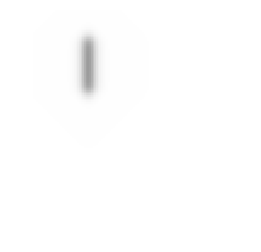

C:\Users\Tim\PycharmProjects\smart_drawing\model_encoder.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\Tim\PycharmProjects\smart_drawing\model_encoder.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


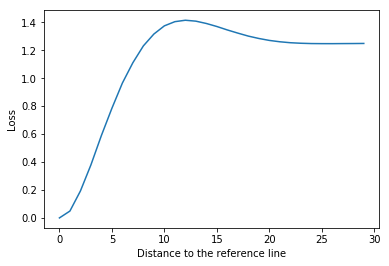

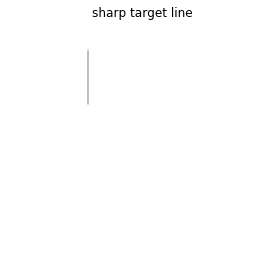

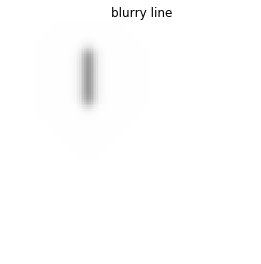

In [3]:
from model_benchmark import *

target_image = get_1line_image(32, 16, 32, 48, sharp=True)
blurry_image = get_1line_image(32, 16, 32, 48, sharp=False)

cnn = CNNFeatureExtractor()
for param in cnn.model.parameters():  # the cnn feature extractor has already been trained, we freeze its parameters
    param.requires_grad = False
cnn.add_comparison_loss(target_image)

losses_without_blurryness = []
losses_with_blurryness = []
for k in range(30):
    sharp_drawing = get_1line_image(32 + k, 16, 32 + k, 48, sharp=True)
    losses_without_blurryness.append(cnn.comparison_loss(cnn.model(sharp_drawing)))
    blurry_drawing = get_1line_image(32 + k, 16, 32 + k, 48, sharp=False)
    losses_with_blurryness.append(cnn.comparison_loss(cnn.model(blurry_drawing)))
    

imshow(target_image, title="sharp target line")
imshow(blurry_image, title="blurry line")

Above you can see the 'sharp' target line to which we are going to compare each drawn line. Below it is displayed the kind of lines we draw.

With the following cell we show the impact of blurrying lines on the ability of the CNN to detect when the drawn line is close to its target. We see that the gradient is different than zero for a larger area in terms of pixels than we don't use the blurrying trick.

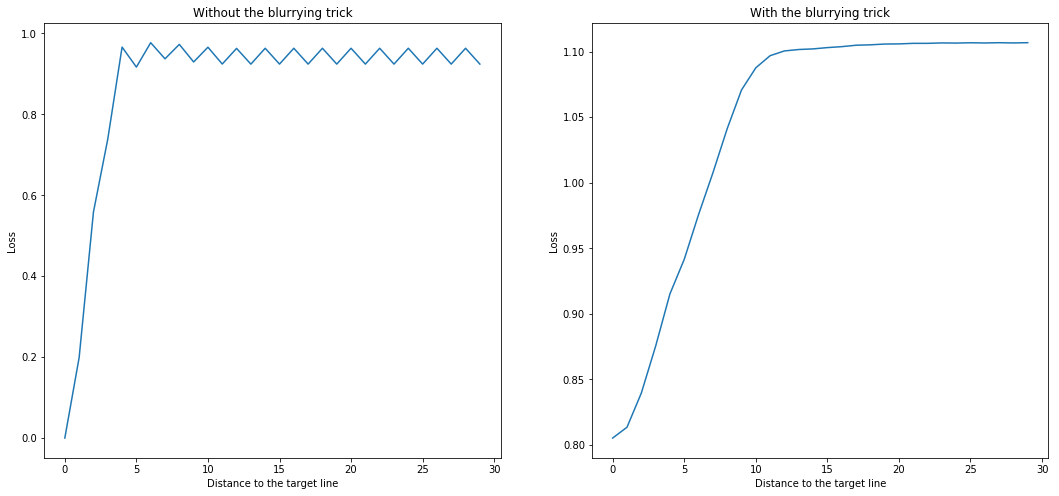

In [4]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(losses_without_blurryness)), losses_without_blurryness)
plt.xlabel("Distance to the target line")
plt.ylabel("Loss")
plt.title("Without the blurrying trick")
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(losses_with_blurryness)), losses_with_blurryness)
plt.xlabel("Distance to the target line")
plt.ylabel("Loss")
plt.title("With the blurrying trick")
plt.show()

We show here using the simple example where the target image is just a single line that when we use the blurrying trick, the optimization of the coordinates of the line we draw works perfectly.

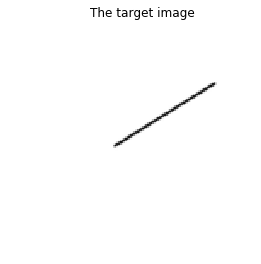

Drawing line number 0
Initializing the line..
Current best line initialization loss:  8.303461074829102
Current best line initialization loss:  7.9212727546691895
Current best line initialization loss:  7.847399711608887
Current best line initialization loss:  7.735031604766846
Current best line initialization loss:  6.020734786987305


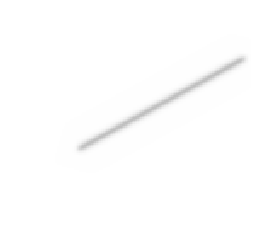

Optimizing the line..


100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Final loss :  4.962590217590332


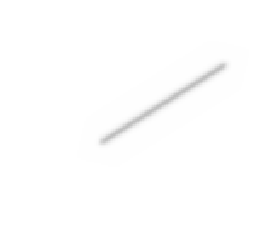

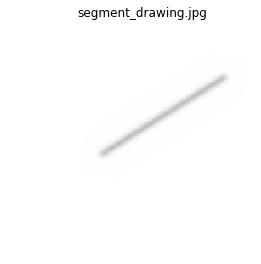

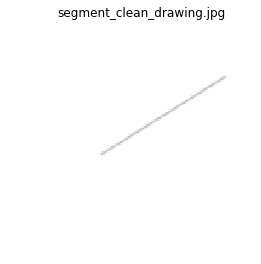

In [5]:
imshow(image_loader("./Images/segment.jpg"), title="The target image")
n_epochs = 50
drawer = run(image_loader("./Images/segment.jpg"), 1, n_epochs, unblur=True, save=False, save_title='segment')

We display here the comparison loss between the target image and the unfinished drawing at every step of the optimization. We see that the blurrying trick allows the gradient descent to converge. We also observe that initializing randomly and selecting the best initialization is not enough in order to draw the target image, the optimization step of the drawing is also necessary since it allows to considerably reduce the comparison loss between the target image and the drawing.

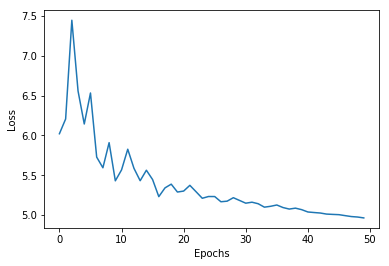

In [6]:
history = drawer.loss_history
plt.figure()
plt.plot(np.arange(n_epochs), history[:n_epochs])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Using ARIEL

Here are displayed several examples of drawings done by ARIEL, the function ```run``` is what actually runs the computation of the drawing, it has many arguments we will describe here:
- ```n_lines``` is an integer that corresponds the number of straight lines used to draw the sketch, it is determined before the drawing
- ```n_epochs``` is an integer, it is the number of iterations in the optimization of each line
- ```clean``` is a boolean that determines whether or not we will show at the end of the computations another version of the drawing where the lines will have been "unblurried"
- ```save``` is a boolean that indicates whether you want to save the final drawing
- ```save_title``` is a str that indicates the path here you would like to save the results if save were True (you don't need to add the .jpg extension to that path)

<a id='section2'></a>

# Drawing simple geometric figures

In [9]:
# imsize = 
# The default value for imsize is 128, you can uncomment the above line to give it any value you wish
# the higher it is the more details you will have but the drawing will take more time
# the expected runtime we give were obtained with imsize = 128

n_epochs = 40 # the number of iterations in the optimization of each line
print("The drawings will be done on a %i x %i canvas" % (imsize, imsize))

The drawings will be done on a 128 x 128 canvas


The target image:

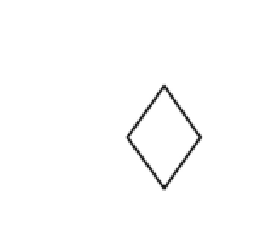

In [10]:
imshow(image_loader("./Images/losange.jpg"))

The drawing: (Expected runtime 45s)

In [11]:
n_lines = 10

Drawing line number 0
Initializing the line..


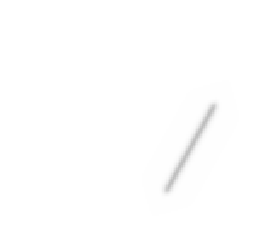

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 38.71it/s]


Final loss :  13.853954315185547


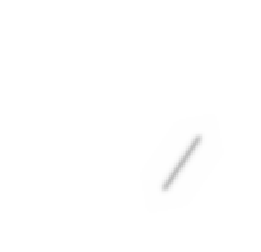

Drawing line number 1
Initializing the line..
Current best line initialization loss:  14.6685152053833
Current best line initialization loss:  13.899215698242188
Current best line initialization loss:  13.505792617797852


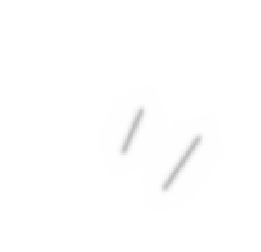

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 38.12it/s]


Final loss :  12.249648094177246


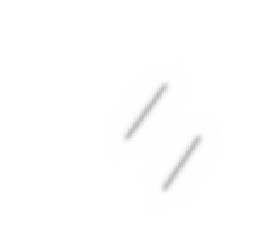

Drawing line number 2
Initializing the line..
Current best line initialization loss:  13.3720703125
Current best line initialization loss:  12.696016311645508
Current best line initialization loss:  12.650623321533203
Current best line initialization loss:  12.63692569732666
Current best line initialization loss:  12.385028839111328
Current best line initialization loss:  12.320525169372559
Current best line initialization loss:  11.710811614990234


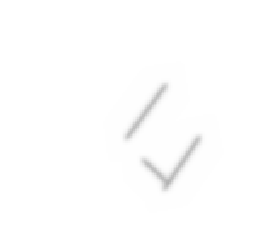

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.10it/s]


Final loss :  12.281477928161621


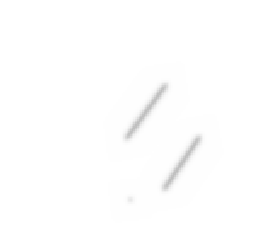

Drawing line number 3
Initializing the line..
Current best line initialization loss:  12.795757293701172
Current best line initialization loss:  12.18755054473877


KeyboardInterrupt: 

In [13]:
drawer = run(image_loader("./Images/losange.jpg"), n_lines, n_epochs, unblur=True, save=False, save_title='losange')

The target image:

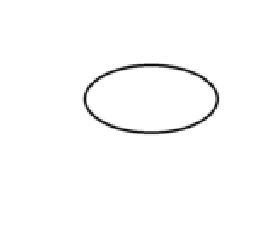

In [14]:
imshow(image_loader("./Images/ovale.jpg"))

The drawing: (Expected runtime 3m 45s

In [15]:
n_lines = 50

Drawing line number 0
Initializing the line..
Current best line initialization loss:  15.488057136535645
Current best line initialization loss:  15.267763137817383
Current best line initialization loss:  15.068612098693848
Current best line initialization loss:  14.960763931274414
Current best line initialization loss:  14.79550552368164


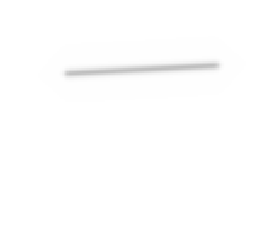

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.71it/s]


Final loss :  14.166051864624023


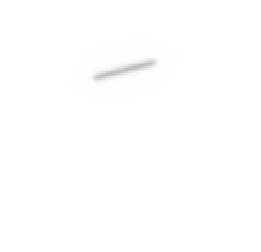

Drawing line number 1
Initializing the line..
Current best line initialization loss:  13.927618026733398
Current best line initialization loss:  13.916485786437988


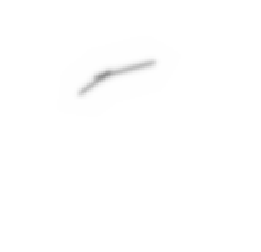

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.47it/s]


Final loss :  13.183282852172852


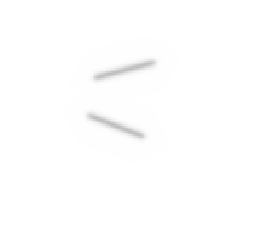

Drawing line number 2
Initializing the line..
Current best line initialization loss:  13.418012619018555
Current best line initialization loss:  13.383509635925293
Current best line initialization loss:  13.377598762512207
Current best line initialization loss:  13.306264877319336
Current best line initialization loss:  13.30434799194336
Current best line initialization loss:  12.484171867370605


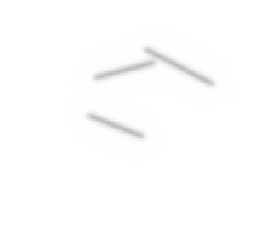

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.67it/s]


Final loss :  12.218461990356445


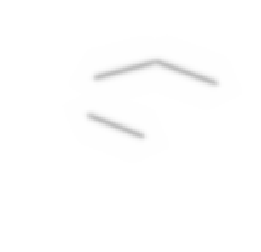

Drawing line number 3
Initializing the line..
Current best line initialization loss:  13.559814453125
Current best line initialization loss:  12.395892143249512
Current best line initialization loss:  11.779624938964844


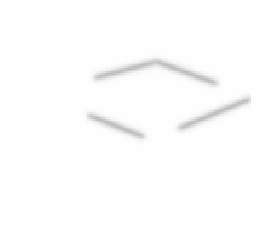

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.87it/s]


Final loss :  11.244827270507812


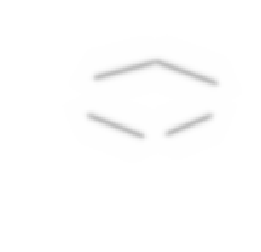

Drawing line number 4
Initializing the line..
Current best line initialization loss:  12.292436599731445
Current best line initialization loss:  12.200573921203613
Current best line initialization loss:  11.753959655761719
Current best line initialization loss:  11.651657104492188
Current best line initialization loss:  11.633394241333008
Current best line initialization loss:  11.399930953979492
Current best line initialization loss:  11.381348609924316
Current best line initialization loss:  11.294632911682129


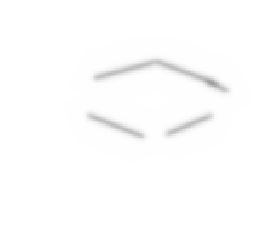

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.43it/s]


Final loss :  10.878767013549805


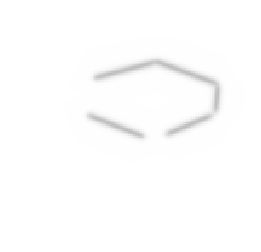

Drawing line number 5
Initializing the line..
Current best line initialization loss:  11.604042053222656
Current best line initialization loss:  11.216304779052734
Current best line initialization loss:  11.109617233276367
Current best line initialization loss:  10.991440773010254


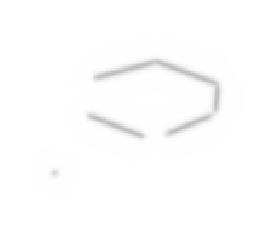

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.18it/s]


Final loss :  10.943777084350586


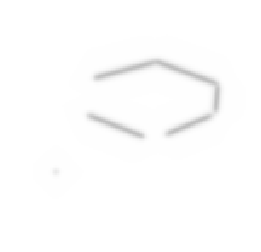

Drawing line number 6
Initializing the line..
Current best line initialization loss:  11.725184440612793
Current best line initialization loss:  11.681599617004395
Current best line initialization loss:  11.436739921569824
Current best line initialization loss:  11.408354759216309
Current best line initialization loss:  11.323441505432129
Current best line initialization loss:  11.235478401184082
Current best line initialization loss:  11.088871955871582
Current best line initialization loss:  10.813678741455078


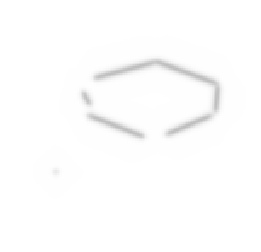

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 38.32it/s]


Final loss :  10.483993530273438


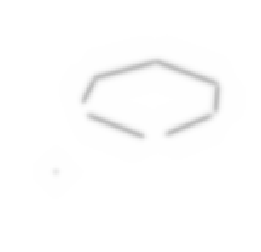

Drawing line number 7
Initializing the line..
Current best line initialization loss:  10.790016174316406
Current best line initialization loss:  10.784202575683594
Current best line initialization loss:  10.699163436889648
Current best line initialization loss:  10.69721794128418
Current best line initialization loss:  10.680484771728516


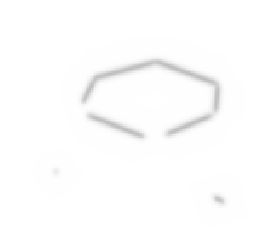

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 38.97it/s]


Final loss :  10.574052810668945


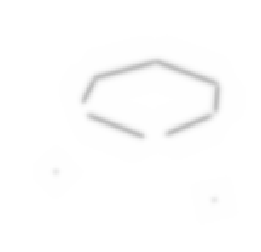

Drawing line number 8
Initializing the line..
Current best line initialization loss:  10.747007369995117
Current best line initialization loss:  10.694913864135742


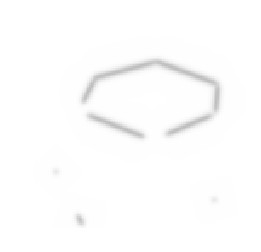

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 33.30it/s]


Final loss :  10.540290832519531


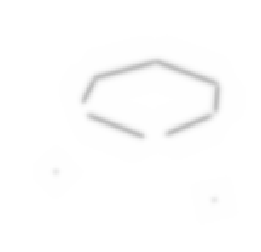

Drawing line number 9
Initializing the line..
Current best line initialization loss:  10.897967338562012
Current best line initialization loss:  10.87519645690918
Current best line initialization loss:  10.576278686523438


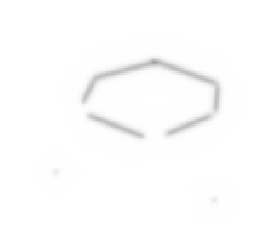

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.69it/s]


Final loss :  10.509921073913574


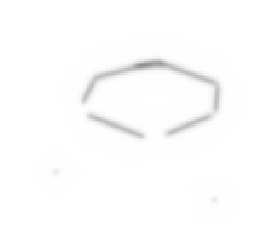

Drawing line number 10
Initializing the line..
Current best line initialization loss:  11.252532958984375
Current best line initialization loss:  10.716572761535645
Current best line initialization loss:  10.627776145935059


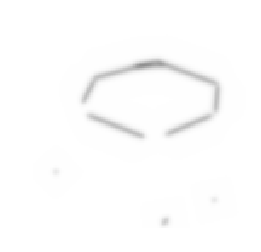

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 35.86it/s]


Final loss :  10.509486198425293


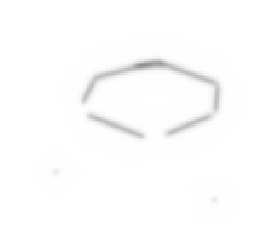

Drawing line number 11
Initializing the line..
Current best line initialization loss:  11.175512313842773
Current best line initialization loss:  11.000419616699219
Current best line initialization loss:  10.976195335388184
Current best line initialization loss:  10.954692840576172
Current best line initialization loss:  10.843425750732422
Current best line initialization loss:  10.776165008544922
Current best line initialization loss:  10.734972953796387
Current best line initialization loss:  10.640498161315918


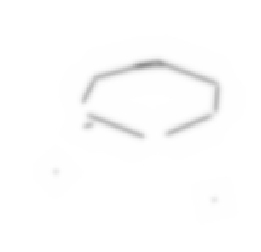

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 38.63it/s]


Final loss :  10.284088134765625


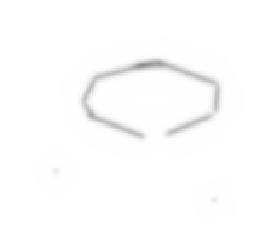

Drawing line number 12
Initializing the line..
Current best line initialization loss:  11.737388610839844
Current best line initialization loss:  11.457284927368164
Current best line initialization loss:  10.75140380859375
Current best line initialization loss:  10.4212007522583
Current best line initialization loss:  10.30145263671875


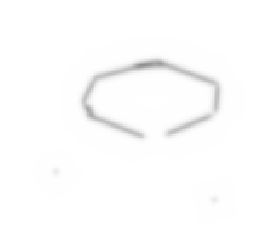

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 29.27it/s]


Final loss :  10.271404266357422


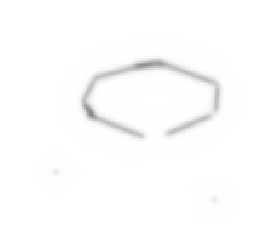

Drawing line number 13
Initializing the line..
Current best line initialization loss:  10.464298248291016
Current best line initialization loss:  10.441781997680664
Current best line initialization loss:  10.401410102844238


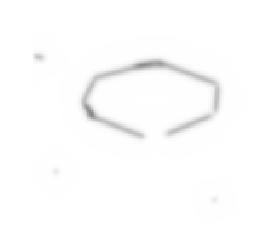

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.05it/s]


Final loss :  10.271293640136719


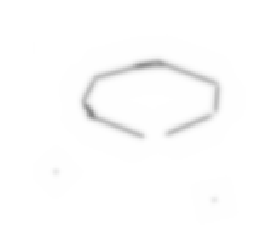

Drawing line number 14
Initializing the line..
Current best line initialization loss:  11.325185775756836
Current best line initialization loss:  11.08289909362793
Current best line initialization loss:  10.783437728881836
Current best line initialization loss:  10.775646209716797
Current best line initialization loss:  10.663891792297363
Current best line initialization loss:  10.485522270202637
Current best line initialization loss:  10.409322738647461


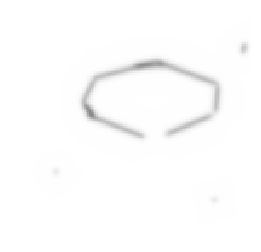

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.67it/s]


Final loss :  10.271292686462402


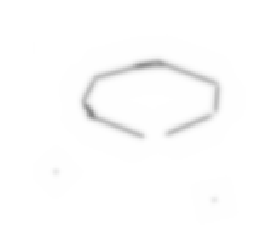

Drawing line number 15
Initializing the line..
Current best line initialization loss:  10.405509948730469
Current best line initialization loss:  10.352086067199707


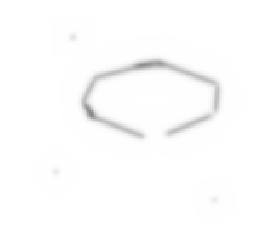

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.18it/s]


Final loss :  10.32359504699707


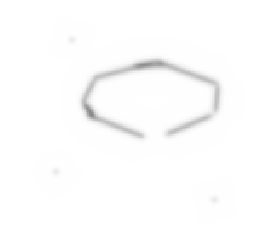

Drawing line number 16
Initializing the line..
Current best line initialization loss:  10.564983367919922
Current best line initialization loss:  10.506805419921875
Current best line initialization loss:  10.503559112548828
Current best line initialization loss:  10.429506301879883


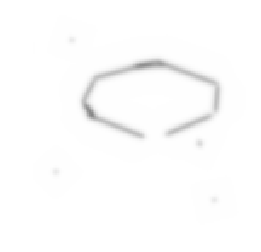

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.29it/s]


Final loss :  10.405150413513184


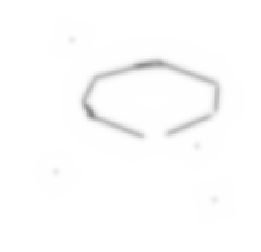

Drawing line number 17
Initializing the line..
Current best line initialization loss:  11.09761905670166
Current best line initialization loss:  10.843376159667969
Current best line initialization loss:  10.652788162231445
Current best line initialization loss:  10.49641227722168


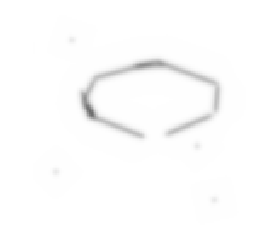

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.40it/s]


Final loss :  10.39747428894043


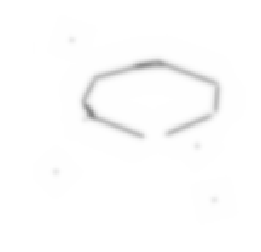

Drawing line number 18
Initializing the line..
Current best line initialization loss:  11.131585121154785
Current best line initialization loss:  11.129522323608398
Current best line initialization loss:  10.82382869720459
Current best line initialization loss:  10.754802703857422
Current best line initialization loss:  10.754486083984375
Current best line initialization loss:  10.723312377929688
Current best line initialization loss:  10.707138061523438
Current best line initialization loss:  10.568023681640625
Current best line initialization loss:  10.43614673614502


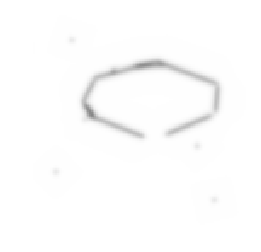

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.76it/s]


Final loss :  10.414316177368164


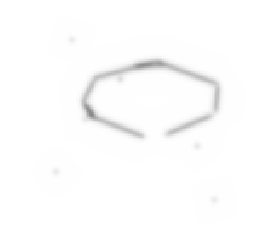

Drawing line number 19
Initializing the line..
Current best line initialization loss:  10.709314346313477
Current best line initialization loss:  10.502066612243652


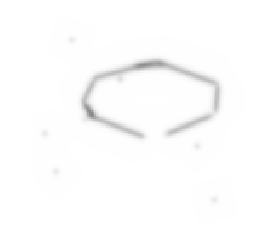

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 33.77it/s]


Final loss :  10.438145637512207


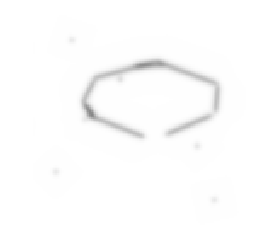

Drawing line number 20
Initializing the line..
Current best line initialization loss:  10.895622253417969
Current best line initialization loss:  10.75322437286377
Current best line initialization loss:  10.71195125579834
Current best line initialization loss:  10.664060592651367
Current best line initialization loss:  10.644512176513672
Current best line initialization loss:  10.585039138793945


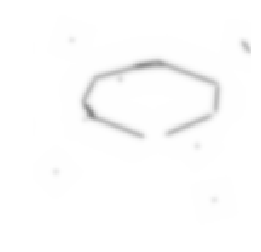

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 35.90it/s]


Final loss :  10.438145637512207


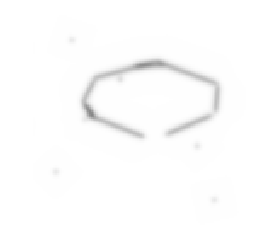

Drawing line number 21
Initializing the line..
Current best line initialization loss:  10.825321197509766
Current best line initialization loss:  10.741538047790527
Current best line initialization loss:  10.583772659301758
Current best line initialization loss:  10.552119255065918
Current best line initialization loss:  10.50633716583252
Current best line initialization loss:  10.486495018005371


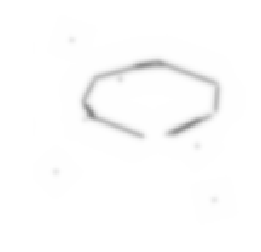

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.02it/s]


Final loss :  10.468222618103027


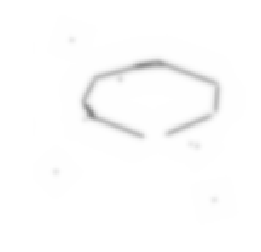

Drawing line number 22
Initializing the line..
Current best line initialization loss:  10.825634956359863
Current best line initialization loss:  10.771097183227539
Current best line initialization loss:  10.588146209716797


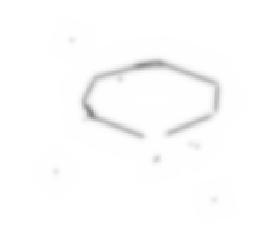

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 35.20it/s]


Final loss :  10.48038101196289


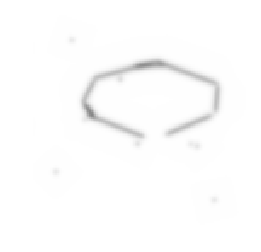

Drawing line number 23
Initializing the line..
Current best line initialization loss:  11.516925811767578
Current best line initialization loss:  11.471477508544922
Current best line initialization loss:  10.714410781860352
Current best line initialization loss:  10.638601303100586
Current best line initialization loss:  10.600513458251953


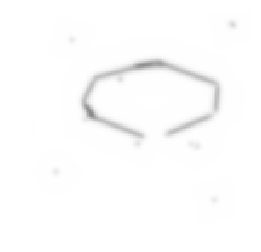

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.15it/s]


Final loss :  10.488861083984375


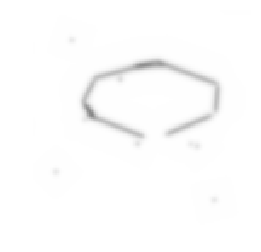

Drawing line number 24
Initializing the line..
Current best line initialization loss:  10.922002792358398
Current best line initialization loss:  10.754297256469727
Current best line initialization loss:  10.719595909118652
Current best line initialization loss:  10.636434555053711


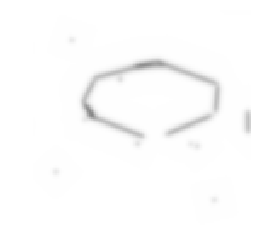

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.86it/s]


Final loss :  10.488861083984375


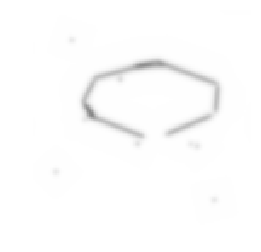

Drawing line number 25
Initializing the line..
Current best line initialization loss:  10.836275100708008
Current best line initialization loss:  10.774922370910645
Current best line initialization loss:  10.76852798461914
Current best line initialization loss:  10.697063446044922


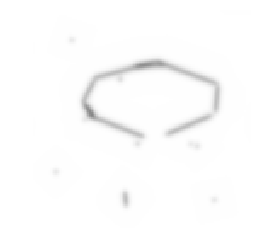

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.50it/s]


Final loss :  10.548164367675781


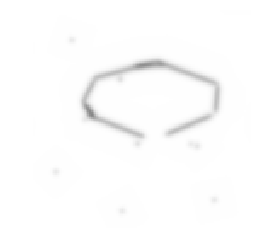

Drawing line number 26
Initializing the line..
Current best line initialization loss:  11.436095237731934
Current best line initialization loss:  11.021805763244629
Current best line initialization loss:  10.81662654876709
Current best line initialization loss:  10.739060401916504
Current best line initialization loss:  10.725991249084473


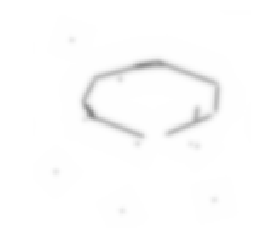

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 33.86it/s]


Final loss :  10.588970184326172


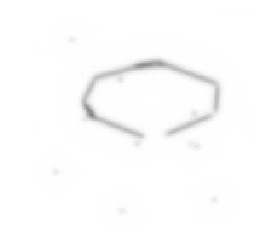

Drawing line number 27
Initializing the line..
Current best line initialization loss:  10.840246200561523
Current best line initialization loss:  10.811115264892578
Current best line initialization loss:  10.804689407348633
Current best line initialization loss:  10.705892562866211


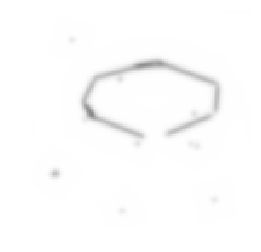

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 35.07it/s]


Final loss :  10.602821350097656


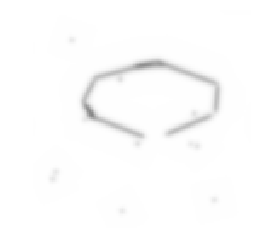

Drawing line number 28
Initializing the line..
Current best line initialization loss:  11.892173767089844
Current best line initialization loss:  11.047615051269531
Current best line initialization loss:  10.98255443572998
Current best line initialization loss:  10.954212188720703
Current best line initialization loss:  10.887334823608398
Current best line initialization loss:  10.885941505432129
Current best line initialization loss:  10.806145668029785
Current best line initialization loss:  10.712224960327148


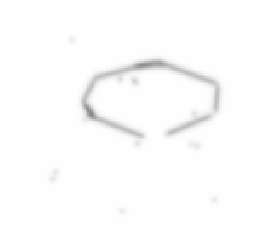

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.68it/s]


Final loss :  10.63577651977539


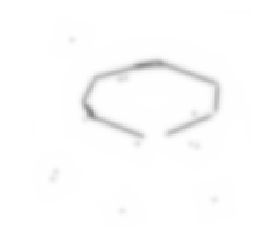

Drawing line number 29
Initializing the line..
Current best line initialization loss:  11.08561897277832
Current best line initialization loss:  10.956348419189453
Current best line initialization loss:  10.883355140686035
Current best line initialization loss:  10.874495506286621
Current best line initialization loss:  10.862754821777344
Current best line initialization loss:  10.828259468078613


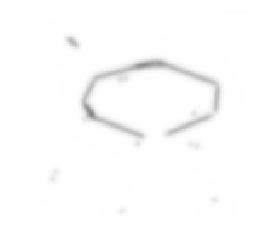

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 31.56it/s]


Final loss :  10.65791130065918


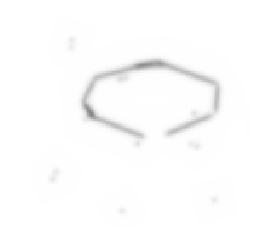

Drawing line number 30
Initializing the line..
Current best line initialization loss:  10.776573181152344
Current best line initialization loss:  10.768766403198242


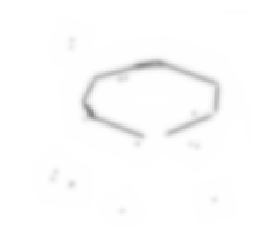

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 30.15it/s]


Final loss :  10.681095123291016


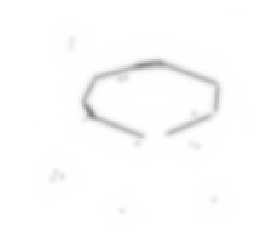

Drawing line number 31
Initializing the line..
Current best line initialization loss:  10.891226768493652
Current best line initialization loss:  10.851401329040527
Current best line initialization loss:  10.833398818969727
Current best line initialization loss:  10.795459747314453


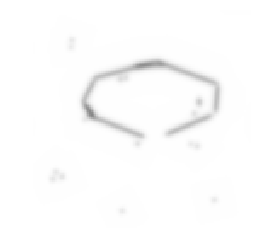

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 33.27it/s]


Final loss :  10.695116996765137


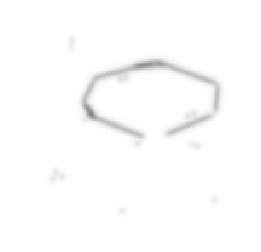

Drawing line number 32
Initializing the line..
Current best line initialization loss:  11.056964874267578
Current best line initialization loss:  10.927044868469238
Current best line initialization loss:  10.902729034423828
Current best line initialization loss:  10.8804931640625
Current best line initialization loss:  10.844762802124023


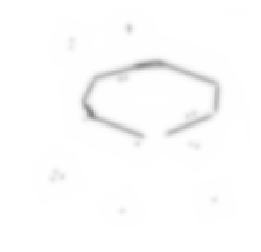

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 35.29it/s]


Final loss :  10.785086631774902


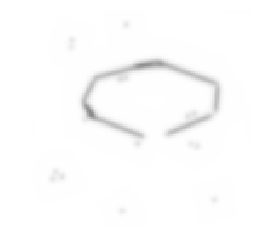

Drawing line number 33
Initializing the line..
Current best line initialization loss:  11.11064624786377
Current best line initialization loss:  10.964117050170898
Current best line initialization loss:  10.953607559204102
Current best line initialization loss:  10.882004737854004


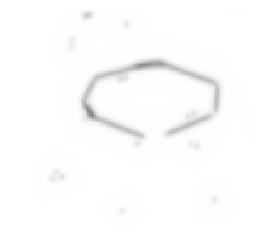

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 30.79it/s]


Final loss :  10.765893936157227


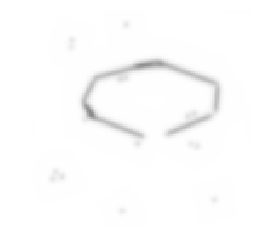

Drawing line number 34
Initializing the line..
Current best line initialization loss:  11.023698806762695
Current best line initialization loss:  10.967935562133789
Current best line initialization loss:  10.849461555480957


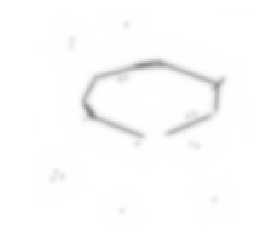

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.53it/s]


Final loss :  10.659463882446289


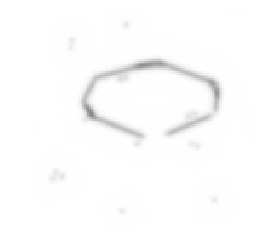

Drawing line number 35
Initializing the line..
Current best line initialization loss:  11.31005859375
Current best line initialization loss:  10.766718864440918


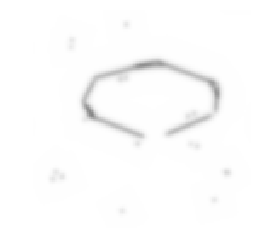

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 28.90it/s]


Final loss :  10.712512969970703


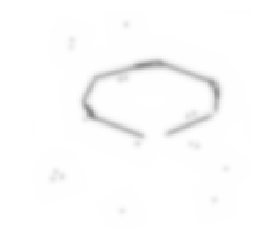

Drawing line number 36
Initializing the line..
Current best line initialization loss:  11.135597229003906
Current best line initialization loss:  11.065118789672852
Current best line initialization loss:  11.027750015258789
Current best line initialization loss:  10.838006973266602
Current best line initialization loss:  10.765653610229492


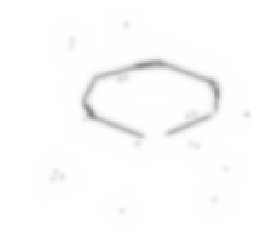

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 37.79it/s]


Final loss :  10.710138320922852


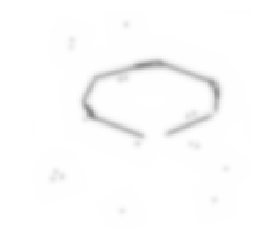

Drawing line number 37
Initializing the line..
Current best line initialization loss:  11.221939086914062
Current best line initialization loss:  11.116962432861328
Current best line initialization loss:  11.006649017333984
Current best line initialization loss:  10.906074523925781
Current best line initialization loss:  10.901649475097656
Current best line initialization loss:  10.87171745300293
Current best line initialization loss:  10.850330352783203


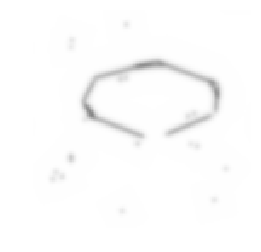

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.82it/s]


Final loss :  10.790731430053711


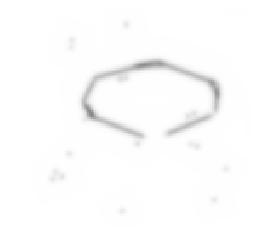

Drawing line number 38
Initializing the line..
Current best line initialization loss:  10.919166564941406
Current best line initialization loss:  10.850761413574219
Current best line initialization loss:  10.846790313720703


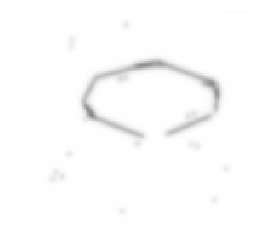

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.98it/s]


Final loss :  10.75699234008789


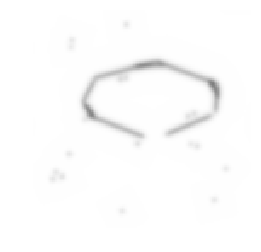

Drawing line number 39
Initializing the line..
Current best line initialization loss:  11.157258033752441
Current best line initialization loss:  11.085014343261719
Current best line initialization loss:  10.920202255249023
Current best line initialization loss:  10.854352951049805
Current best line initialization loss:  10.811452865600586


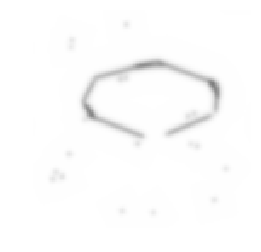

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.56it/s]


Final loss :  10.764208793640137


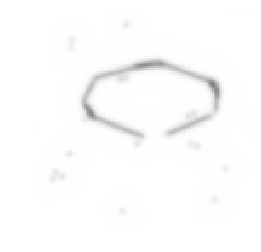

Drawing line number 40
Initializing the line..
Current best line initialization loss:  11.78291130065918
Current best line initialization loss:  11.514223098754883
Current best line initialization loss:  11.43613338470459
Current best line initialization loss:  11.318523406982422
Current best line initialization loss:  11.316092491149902
Current best line initialization loss:  11.27569580078125
Current best line initialization loss:  11.15927505493164
Current best line initialization loss:  10.994942665100098
Current best line initialization loss:  10.857522964477539
Current best line initialization loss:  10.836653709411621


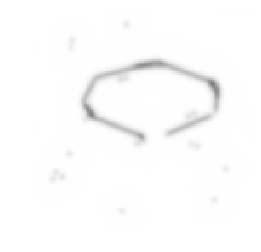

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.57it/s]


Final loss :  10.48810863494873


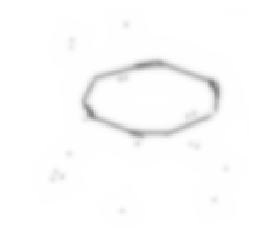

Drawing line number 41
Initializing the line..
Current best line initialization loss:  11.404533386230469
Current best line initialization loss:  11.270556449890137
Current best line initialization loss:  11.048630714416504
Current best line initialization loss:  10.880964279174805
Current best line initialization loss:  10.829465866088867
Current best line initialization loss:  10.810791015625
Current best line initialization loss:  10.804301261901855
Current best line initialization loss:  10.780196189880371
Current best line initialization loss:  10.738480567932129
Current best line initialization loss:  10.706523895263672
Current best line initialization loss:  10.602354049682617


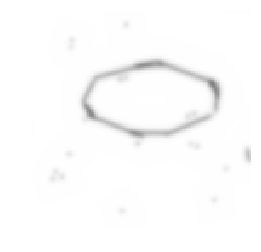

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 37.23it/s]


Final loss :  10.490396499633789


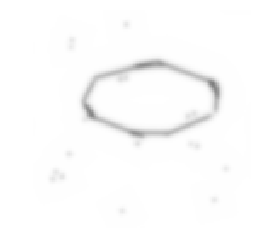

Drawing line number 42
Initializing the line..
Current best line initialization loss:  11.039429664611816
Current best line initialization loss:  11.019229888916016
Current best line initialization loss:  10.619940757751465
Current best line initialization loss:  10.562166213989258


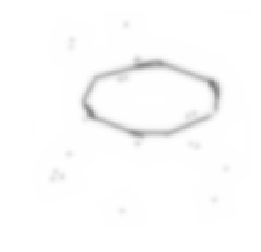

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 30.02it/s]


Final loss :  10.406122207641602


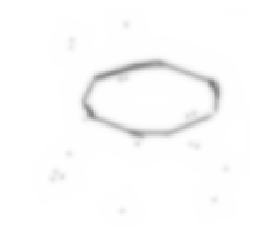

Drawing line number 43
Initializing the line..
Current best line initialization loss:  11.285547256469727
Current best line initialization loss:  11.254903793334961
Current best line initialization loss:  10.849851608276367
Current best line initialization loss:  10.761627197265625
Current best line initialization loss:  10.74583625793457
Current best line initialization loss:  10.597487449645996
Current best line initialization loss:  10.586215019226074
Current best line initialization loss:  10.555340766906738
Current best line initialization loss:  10.442102432250977


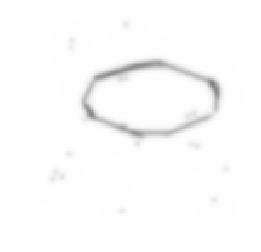

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.21it/s]


Final loss :  10.409347534179688


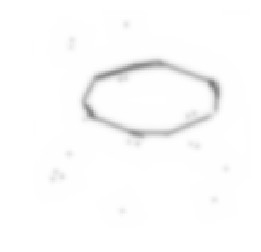

Drawing line number 44
Initializing the line..
Current best line initialization loss:  10.480951309204102
Current best line initialization loss:  10.468746185302734
Current best line initialization loss:  10.451566696166992


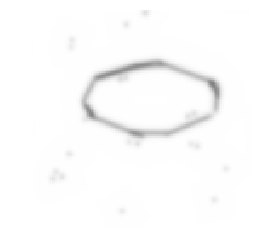

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 32.51it/s]


Final loss :  10.406274795532227


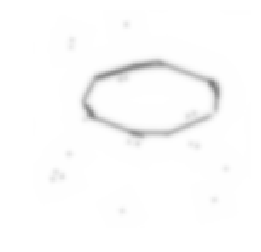

Drawing line number 45
Initializing the line..
Current best line initialization loss:  10.739681243896484
Current best line initialization loss:  10.662164688110352
Current best line initialization loss:  10.661697387695312
Current best line initialization loss:  10.561326026916504


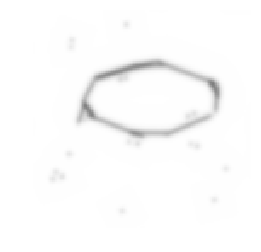

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 32.25it/s]


Final loss :  10.409753799438477


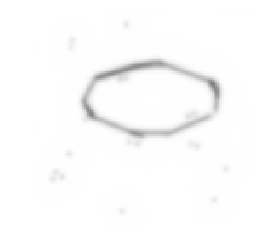

Drawing line number 46
Initializing the line..
Current best line initialization loss:  10.726970672607422
Current best line initialization loss:  10.616168022155762
Current best line initialization loss:  10.590696334838867
Current best line initialization loss:  10.51733112335205


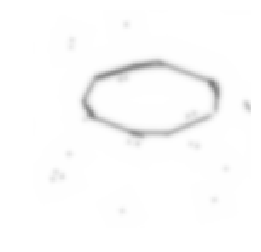

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 32.27it/s]


Final loss :  10.41076374053955


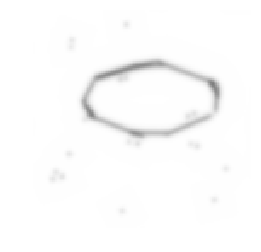

Drawing line number 47
Initializing the line..
Current best line initialization loss:  10.7095308303833
Current best line initialization loss:  10.556025505065918
Current best line initialization loss:  10.546590805053711
Current best line initialization loss:  10.44084358215332


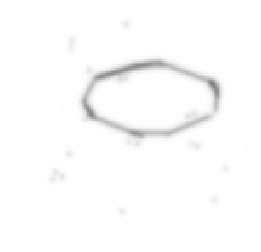

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 31.61it/s]


Final loss :  10.425875663757324


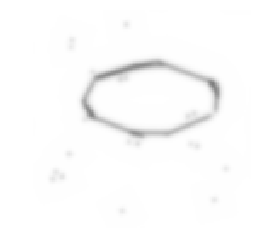

Drawing line number 48
Initializing the line..
Current best line initialization loss:  10.711624145507812
Current best line initialization loss:  10.638059616088867
Current best line initialization loss:  10.524420738220215


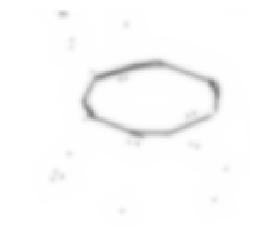

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 37.41it/s]


Final loss :  10.423593521118164


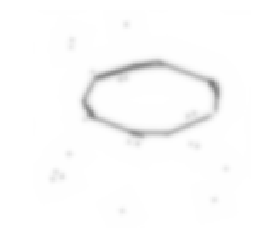

Drawing line number 49
Initializing the line..
Current best line initialization loss:  11.385185241699219
Current best line initialization loss:  11.148894309997559
Current best line initialization loss:  11.085351943969727
Current best line initialization loss:  10.900957107543945
Current best line initialization loss:  10.435014724731445


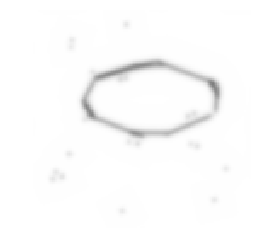

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.71it/s]


Final loss :  10.424283981323242


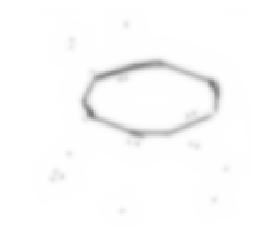

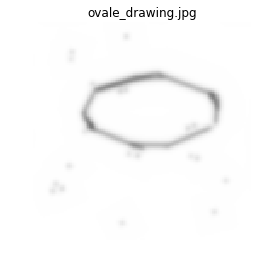

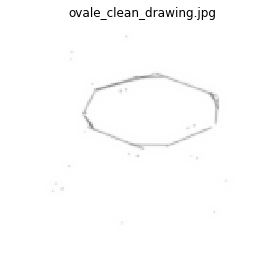

In [16]:
drawer = run(image_loader("./Images/ovale.jpg"), n_lines, n_epochs, unblur=True, save=False, save_title='ovale')

### Combining thin lines to create thicker lines

An amusing discovery was that when the lines in the targer image were wider than the ones used by the drawer, it would add many lines to create something that looks like the original. Here is an example where it had to do that:

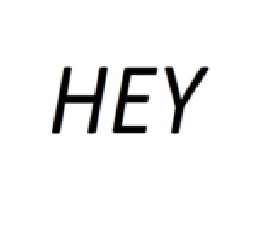

In [17]:
imshow(image_loader("./Images/texte.jpg"))

Drawing line number 0
Initializing the line..
Current best line initialization loss:  28.733659744262695
Current best line initialization loss:  28.01473045349121
Current best line initialization loss:  27.942657470703125
Current best line initialization loss:  27.913837432861328
Current best line initialization loss:  27.814205169677734
Current best line initialization loss:  27.726253509521484
Current best line initialization loss:  27.637691497802734


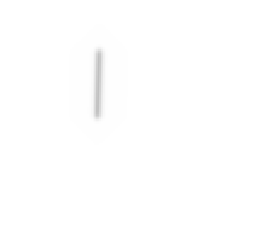

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 33.35it/s]


Final loss :  26.32839012145996


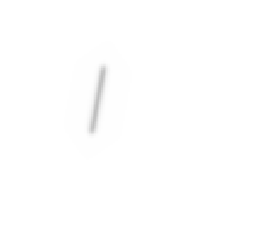

Drawing line number 1
Initializing the line..
Current best line initialization loss:  26.40420913696289
Current best line initialization loss:  26.358762741088867
Current best line initialization loss:  25.941282272338867
Current best line initialization loss:  25.898927688598633


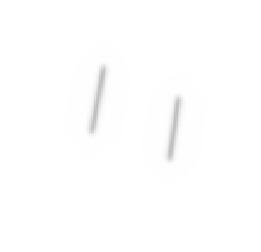

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.59it/s]


Final loss :  24.40439224243164


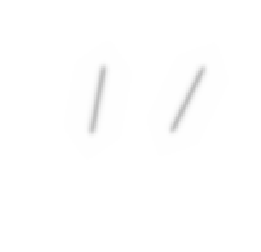

Drawing line number 2
Initializing the line..
Current best line initialization loss:  24.593305587768555
Current best line initialization loss:  24.557497024536133
Current best line initialization loss:  24.37807846069336
Current best line initialization loss:  24.174243927001953


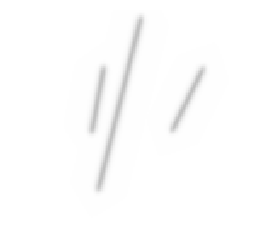

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.43it/s]


Final loss :  22.985157012939453


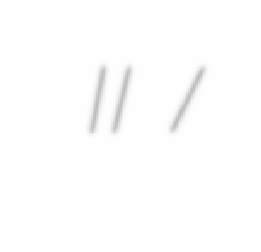

Drawing line number 3
Initializing the line..
Current best line initialization loss:  23.528972625732422
Current best line initialization loss:  23.396337509155273
Current best line initialization loss:  23.327274322509766
Current best line initialization loss:  23.2880859375
Current best line initialization loss:  23.0296573638916
Current best line initialization loss:  22.448286056518555
Current best line initialization loss:  22.406715393066406


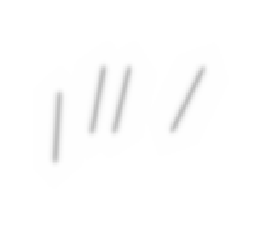

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.53it/s]


Final loss :  20.98443603515625


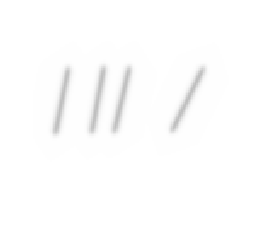

Drawing line number 4
Initializing the line..
Current best line initialization loss:  21.401578903198242
Current best line initialization loss:  21.042232513427734
Current best line initialization loss:  20.897239685058594


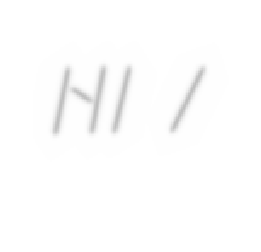

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 37.62it/s]


Final loss :  20.2344913482666


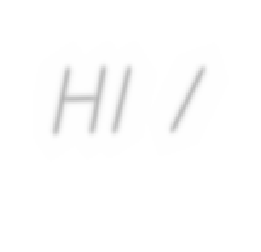

Drawing line number 5
Initializing the line..
Current best line initialization loss:  20.488779067993164
Current best line initialization loss:  20.146568298339844
Current best line initialization loss:  19.94025421142578


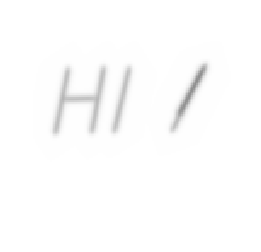

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.27it/s]


Final loss :  19.835176467895508


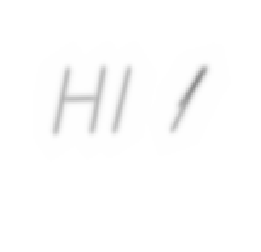

Drawing line number 6
Initializing the line..
Current best line initialization loss:  20.896625518798828
Current best line initialization loss:  20.384765625
Current best line initialization loss:  20.18989372253418
Current best line initialization loss:  20.108341217041016
Current best line initialization loss:  19.30609130859375


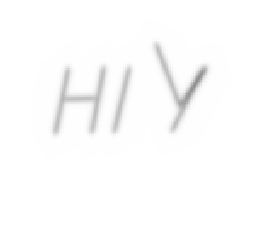

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.29it/s]


Final loss :  19.825145721435547


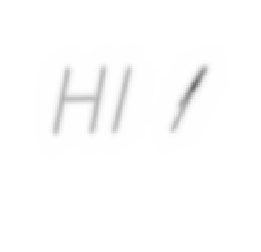

Drawing line number 7
Initializing the line..
Current best line initialization loss:  20.287307739257812
Current best line initialization loss:  20.122997283935547
Current best line initialization loss:  20.044921875
Current best line initialization loss:  19.982845306396484
Current best line initialization loss:  19.96454620361328
Current best line initialization loss:  19.747581481933594
Current best line initialization loss:  19.727458953857422


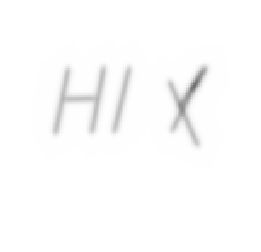

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.39it/s]


Final loss :  18.73727035522461


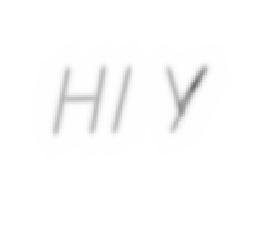

Drawing line number 8
Initializing the line..
Current best line initialization loss:  20.05442237854004
Current best line initialization loss:  19.035293579101562
Current best line initialization loss:  18.7849063873291
Current best line initialization loss:  18.767248153686523
Current best line initialization loss:  18.76456069946289


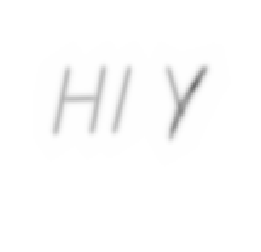

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.67it/s]


Final loss :  18.560577392578125


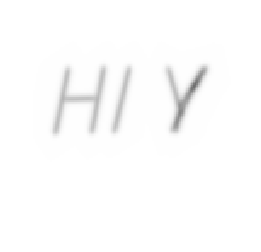

Drawing line number 9
Initializing the line..
Current best line initialization loss:  19.17942237854004
Current best line initialization loss:  18.89462661743164
Current best line initialization loss:  18.860912322998047
Current best line initialization loss:  18.724523544311523
Current best line initialization loss:  18.539066314697266


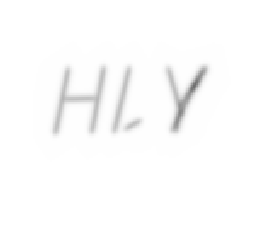

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.92it/s]


Final loss :  17.621166229248047


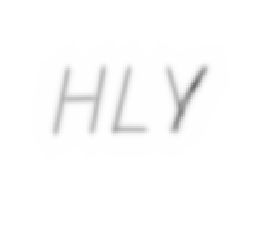

Drawing line number 10
Initializing the line..
Current best line initialization loss:  17.84678077697754
Current best line initialization loss:  17.78827667236328
Current best line initialization loss:  17.773235321044922


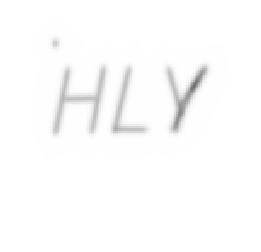

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.32it/s]


Final loss :  17.68937110900879


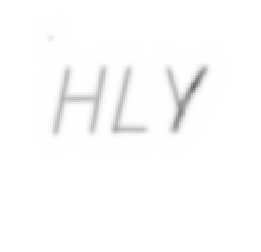

Drawing line number 11
Initializing the line..
Current best line initialization loss:  17.8347225189209
Current best line initialization loss:  17.780521392822266
Current best line initialization loss:  17.759815216064453
Current best line initialization loss:  17.56838035583496


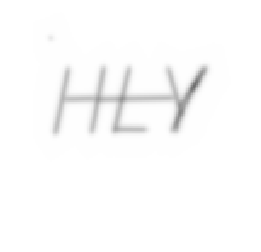

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 35.96it/s]


Final loss :  16.866008758544922


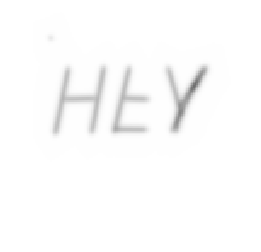

Drawing line number 12
Initializing the line..
Current best line initialization loss:  16.974102020263672


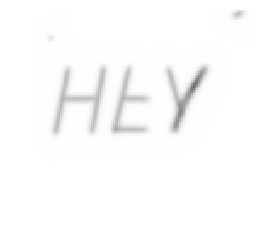

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.43it/s]


Final loss :  16.85683822631836


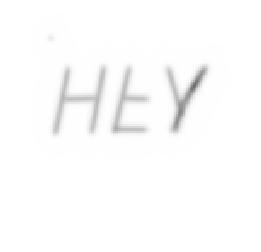

Drawing line number 13
Initializing the line..
Current best line initialization loss:  17.747297286987305
Current best line initialization loss:  17.455005645751953
Current best line initialization loss:  17.412559509277344
Current best line initialization loss:  17.09482192993164
Current best line initialization loss:  17.000080108642578
Current best line initialization loss:  16.9665470123291


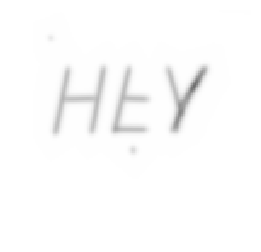

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.06it/s]


Final loss :  16.902437210083008


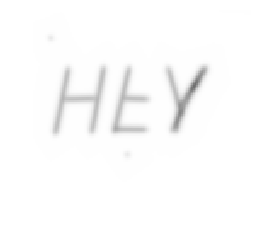

Drawing line number 14
Initializing the line..
Current best line initialization loss:  17.347402572631836
Current best line initialization loss:  17.178401947021484
Current best line initialization loss:  17.05686378479004
Current best line initialization loss:  17.029056549072266
Current best line initialization loss:  17.02895164489746


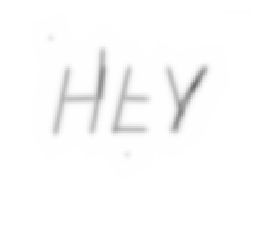

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.06it/s]


Final loss :  16.551862716674805


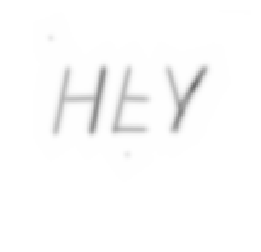

Drawing line number 15
Initializing the line..
Current best line initialization loss:  17.70758056640625
Current best line initialization loss:  17.127737045288086
Current best line initialization loss:  16.88277816772461
Current best line initialization loss:  16.687976837158203
Current best line initialization loss:  16.657432556152344
Current best line initialization loss:  16.584213256835938


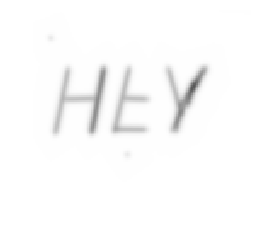

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.09it/s]


Final loss :  16.342395782470703


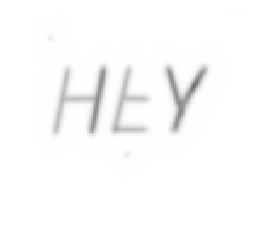

Drawing line number 16
Initializing the line..
Current best line initialization loss:  16.79715347290039
Current best line initialization loss:  16.610931396484375
Current best line initialization loss:  16.44234848022461
Current best line initialization loss:  16.422441482543945


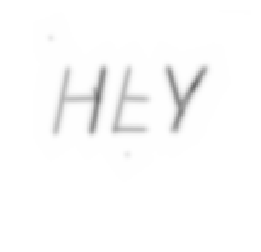

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.43it/s]


Final loss :  16.335350036621094


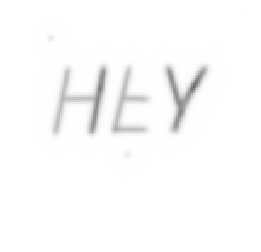

Drawing line number 17
Initializing the line..
Current best line initialization loss:  16.524234771728516
Current best line initialization loss:  16.409282684326172
Current best line initialization loss:  16.312089920043945
Current best line initialization loss:  16.26643180847168


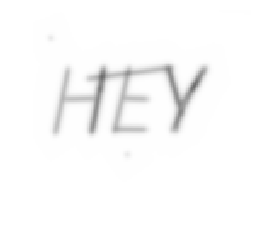

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.85it/s]


Final loss :  15.46167278289795


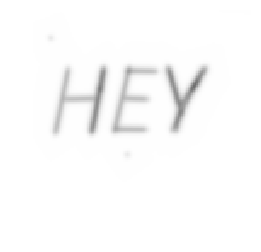

Drawing line number 18
Initializing the line..
Current best line initialization loss:  15.970788955688477
Current best line initialization loss:  15.814661026000977
Current best line initialization loss:  15.728391647338867
Current best line initialization loss:  15.544794082641602


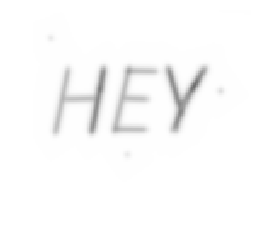

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.69it/s]


Final loss :  15.578363418579102


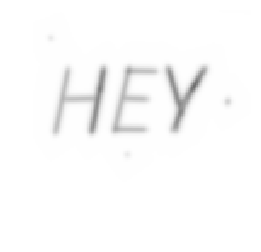

Drawing line number 19
Initializing the line..
Current best line initialization loss:  15.781270980834961
Current best line initialization loss:  15.762977600097656
Current best line initialization loss:  15.71053695678711


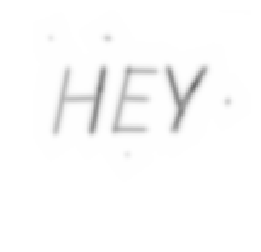

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.38it/s]


Final loss :  15.643583297729492


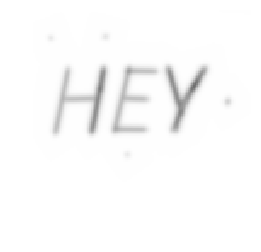

Drawing line number 20
Initializing the line..
Current best line initialization loss:  16.66493034362793
Current best line initialization loss:  16.568973541259766
Current best line initialization loss:  16.14383888244629
Current best line initialization loss:  16.035999298095703
Current best line initialization loss:  15.870222091674805
Current best line initialization loss:  15.805336952209473


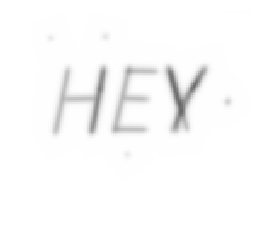

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.08it/s]


Final loss :  15.584365844726562


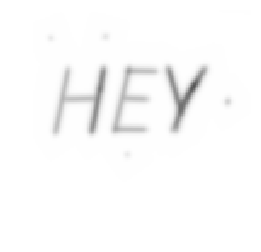

Drawing line number 21
Initializing the line..
Current best line initialization loss:  15.922344207763672
Current best line initialization loss:  15.916572570800781
Current best line initialization loss:  15.914194107055664
Current best line initialization loss:  15.682903289794922


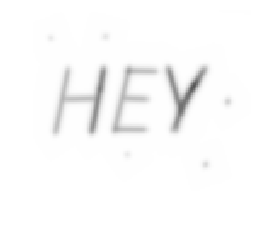

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.39it/s]


Final loss :  15.64530086517334


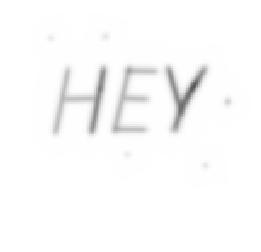

Drawing line number 22
Initializing the line..
Current best line initialization loss:  16.571556091308594
Current best line initialization loss:  16.075666427612305
Current best line initialization loss:  15.957319259643555
Current best line initialization loss:  15.883743286132812
Current best line initialization loss:  15.529325485229492


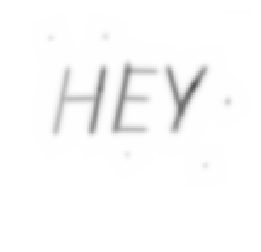

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.18it/s]


Final loss :  15.581598281860352


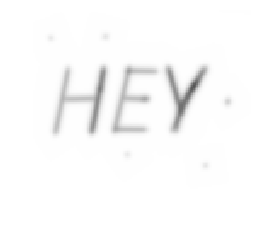

Drawing line number 23
Initializing the line..
Current best line initialization loss:  16.23357391357422
Current best line initialization loss:  16.232830047607422
Current best line initialization loss:  15.930741310119629
Current best line initialization loss:  15.926741600036621
Current best line initialization loss:  15.774030685424805
Current best line initialization loss:  15.730923652648926


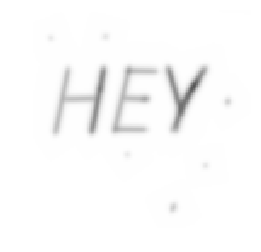

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.83it/s]


Final loss :  15.632498741149902


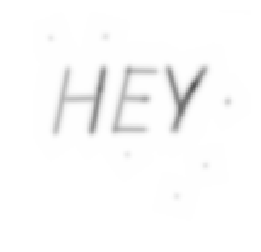

Drawing line number 24
Initializing the line..
Current best line initialization loss:  16.060245513916016
Current best line initialization loss:  15.81527328491211
Current best line initialization loss:  15.79769515991211


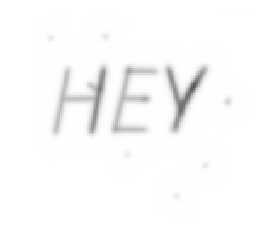

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 38.19it/s]


Final loss :  15.635551452636719


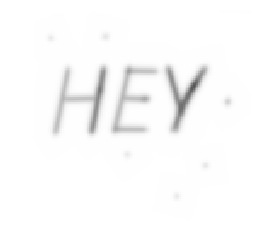

Drawing line number 25
Initializing the line..
Current best line initialization loss:  15.966182708740234
Current best line initialization loss:  15.876134872436523
Current best line initialization loss:  15.871437072753906
Current best line initialization loss:  15.793599128723145


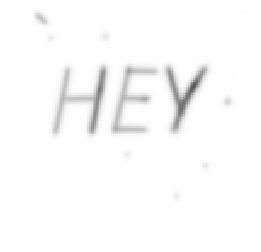

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.85it/s]


Final loss :  15.635210037231445


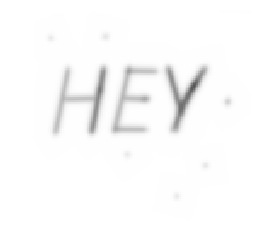

Drawing line number 26
Initializing the line..
Current best line initialization loss:  16.909822463989258
Current best line initialization loss:  16.57172393798828
Current best line initialization loss:  16.13308334350586
Current best line initialization loss:  16.12761688232422
Current best line initialization loss:  16.10218048095703
Current best line initialization loss:  15.954215049743652
Current best line initialization loss:  15.690332412719727


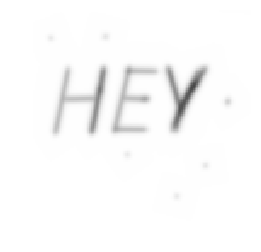

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 33.95it/s]


Final loss :  15.65298080444336


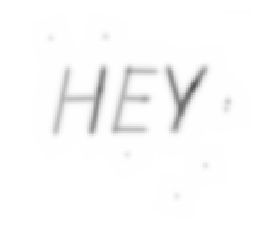

Drawing line number 27
Initializing the line..
Current best line initialization loss:  15.834806442260742
Current best line initialization loss:  15.831962585449219


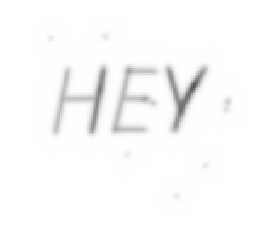

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.85it/s]


Final loss :  15.695024490356445


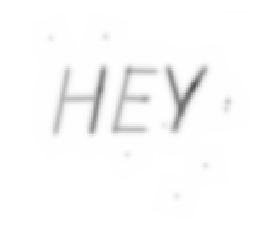

Drawing line number 28
Initializing the line..
Current best line initialization loss:  16.98164939880371
Current best line initialization loss:  16.850704193115234
Current best line initialization loss:  16.41302490234375
Current best line initialization loss:  15.99905776977539
Current best line initialization loss:  15.908540725708008
Current best line initialization loss:  15.70476245880127


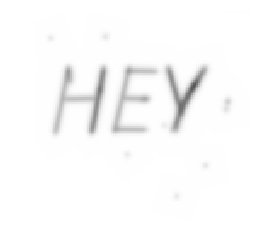

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 37.61it/s]


Final loss :  15.544004440307617


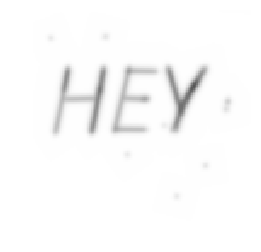

Drawing line number 29
Initializing the line..
Current best line initialization loss:  16.160053253173828
Current best line initialization loss:  16.05763053894043
Current best line initialization loss:  15.806180953979492
Current best line initialization loss:  15.770145416259766
Current best line initialization loss:  15.749654769897461
Current best line initialization loss:  15.597184181213379


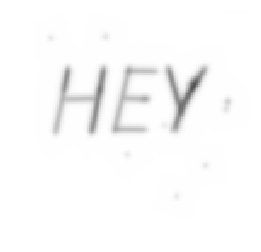

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 35.39it/s]


Final loss :  15.538406372070312


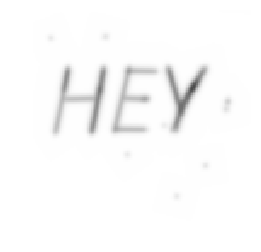

Drawing line number 30
Initializing the line..
Current best line initialization loss:  15.838667869567871
Current best line initialization loss:  15.777043342590332
Current best line initialization loss:  15.768012046813965
Current best line initialization loss:  15.525162696838379


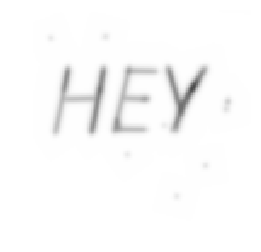

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 37.72it/s]


Final loss :  15.387290000915527


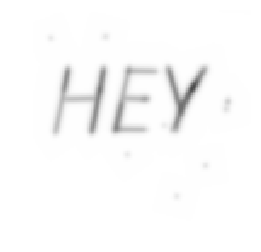

Drawing line number 31
Initializing the line..
Current best line initialization loss:  16.169328689575195
Current best line initialization loss:  16.08220672607422
Current best line initialization loss:  15.887032508850098
Current best line initialization loss:  15.859508514404297
Current best line initialization loss:  15.559843063354492
Current best line initialization loss:  15.508811950683594
Current best line initialization loss:  15.494409561157227
Current best line initialization loss:  15.445442199707031


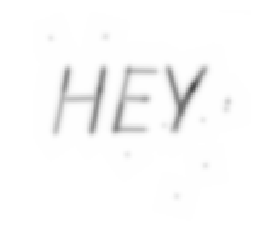

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.75it/s]


Final loss :  15.287019729614258


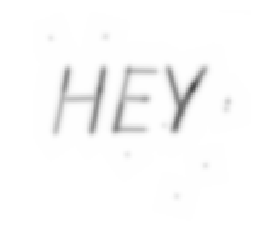

Drawing line number 32
Initializing the line..
Current best line initialization loss:  15.672789573669434
Current best line initialization loss:  15.4838285446167
Current best line initialization loss:  15.43842601776123
Current best line initialization loss:  15.436234474182129


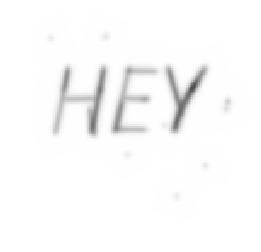

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 37.37it/s]


Final loss :  15.194646835327148


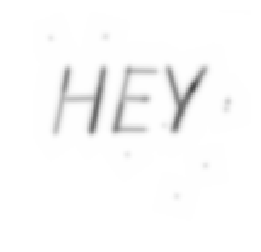

Drawing line number 33
Initializing the line..
Current best line initialization loss:  16.14411735534668
Current best line initialization loss:  15.428943634033203
Current best line initialization loss:  15.40049934387207
Current best line initialization loss:  15.3729248046875
Current best line initialization loss:  15.311972618103027


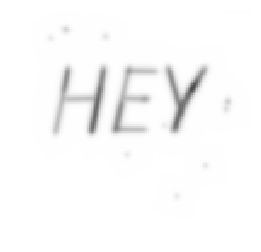

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 30.80it/s]


Final loss :  15.246444702148438


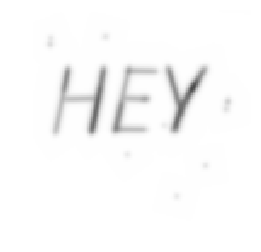

Drawing line number 34
Initializing the line..
Current best line initialization loss:  15.865470886230469
Current best line initialization loss:  15.513898849487305
Current best line initialization loss:  15.366937637329102


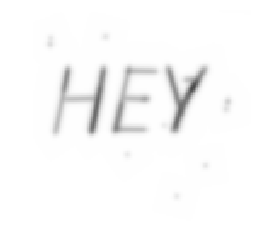

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.17it/s]


Final loss :  15.21746826171875


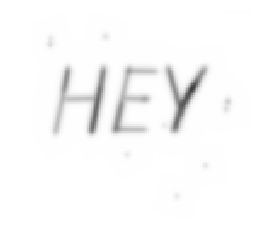

Drawing line number 35
Initializing the line..
Current best line initialization loss:  15.359230041503906
Current best line initialization loss:  15.154670715332031


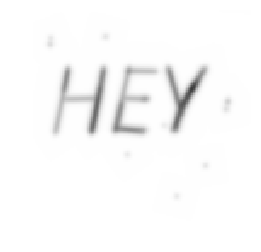

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.33it/s]


Final loss :  15.27365779876709


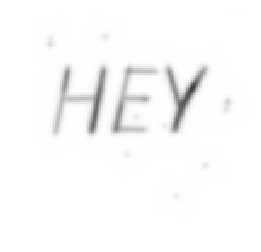

Drawing line number 36
Initializing the line..
Current best line initialization loss:  15.980838775634766
Current best line initialization loss:  15.773111343383789
Current best line initialization loss:  15.607305526733398
Current best line initialization loss:  15.385863304138184


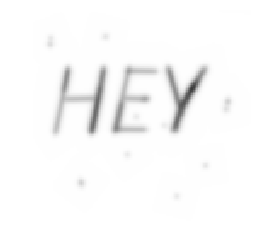

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.25it/s]


Final loss :  15.34528923034668


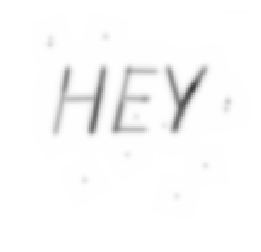

Drawing line number 37
Initializing the line..
Current best line initialization loss:  16.321470260620117
Current best line initialization loss:  15.851421356201172
Current best line initialization loss:  15.742414474487305
Current best line initialization loss:  15.575671195983887
Current best line initialization loss:  15.554800033569336
Current best line initialization loss:  15.517096519470215
Current best line initialization loss:  15.483550071716309
Current best line initialization loss:  15.410745620727539
Current best line initialization loss:  15.333084106445312


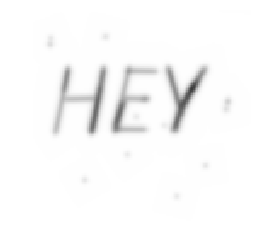

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.90it/s]


Final loss :  15.26791763305664


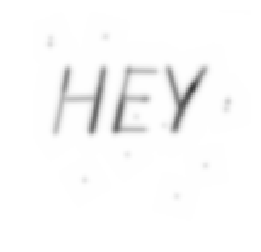

Drawing line number 38
Initializing the line..
Current best line initialization loss:  15.841175079345703
Current best line initialization loss:  15.390527725219727
Current best line initialization loss:  15.35824203491211


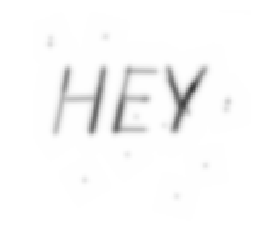

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 35.73it/s]


Final loss :  15.157732009887695


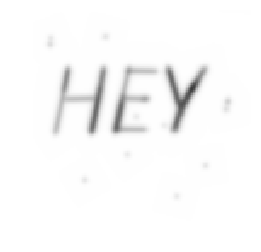

Drawing line number 39
Initializing the line..
Current best line initialization loss:  15.242731094360352


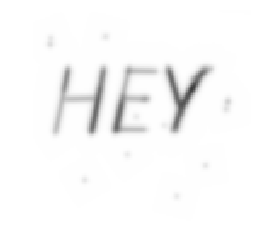

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.91it/s]


Final loss :  15.076343536376953


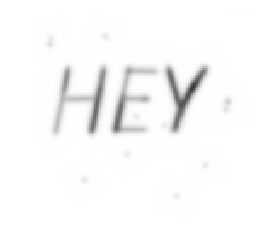

Drawing line number 40
Initializing the line..
Current best line initialization loss:  15.305681228637695
Current best line initialization loss:  15.261212348937988
Current best line initialization loss:  15.26011848449707
Current best line initialization loss:  15.225258827209473


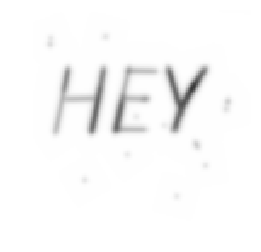

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 37.18it/s]


Final loss :  15.130788803100586


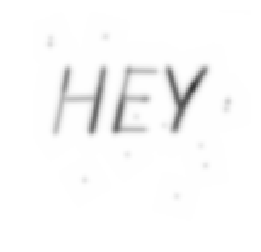

Drawing line number 41
Initializing the line..
Current best line initialization loss:  16.482013702392578
Current best line initialization loss:  15.923358917236328
Current best line initialization loss:  15.394493103027344
Current best line initialization loss:  15.32452392578125


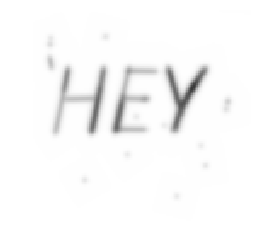

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.38it/s]


Final loss :  15.154245376586914


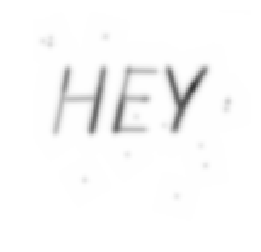

Drawing line number 42
Initializing the line..
Current best line initialization loss:  16.02001953125
Current best line initialization loss:  15.722219467163086
Current best line initialization loss:  15.401325225830078
Current best line initialization loss:  15.398582458496094
Current best line initialization loss:  15.396940231323242
Current best line initialization loss:  15.319074630737305
Current best line initialization loss:  15.30329704284668


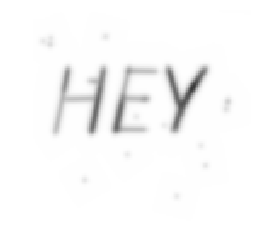

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 38.80it/s]


Final loss :  15.069489479064941


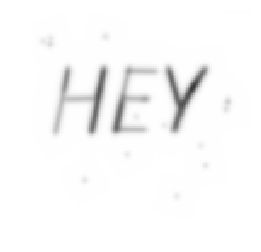

Drawing line number 43
Initializing the line..
Current best line initialization loss:  15.660572052001953
Current best line initialization loss:  15.381768226623535
Current best line initialization loss:  15.025386810302734


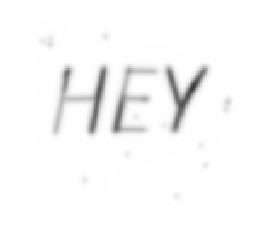

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.70it/s]


Final loss :  14.996965408325195


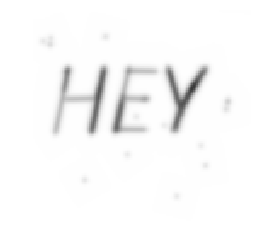

Drawing line number 44
Initializing the line..
Current best line initialization loss:  15.537209510803223
Current best line initialization loss:  15.266885757446289
Current best line initialization loss:  15.25717544555664
Current best line initialization loss:  15.177186965942383
Current best line initialization loss:  15.121845245361328
Current best line initialization loss:  15.10999584197998


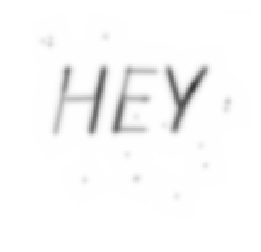

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.35it/s]


Final loss :  15.03052806854248


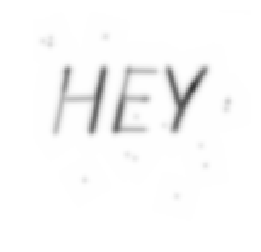

Drawing line number 45
Initializing the line..
Current best line initialization loss:  15.764543533325195
Current best line initialization loss:  15.269211769104004
Current best line initialization loss:  15.238758087158203
Current best line initialization loss:  15.236652374267578
Current best line initialization loss:  15.096027374267578


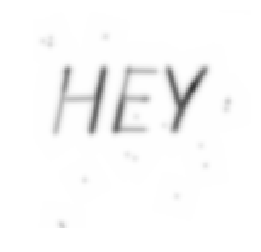

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.21it/s]


Final loss :  15.02336597442627


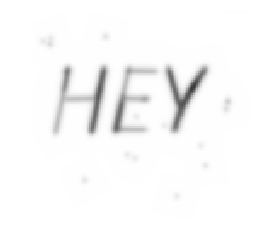

Drawing line number 46
Initializing the line..
Current best line initialization loss:  15.507158279418945
Current best line initialization loss:  15.488798141479492
Current best line initialization loss:  15.481071472167969
Current best line initialization loss:  15.168661117553711
Current best line initialization loss:  15.148794174194336
Current best line initialization loss:  15.132888793945312
Current best line initialization loss:  15.096705436706543
Current best line initialization loss:  15.058723449707031


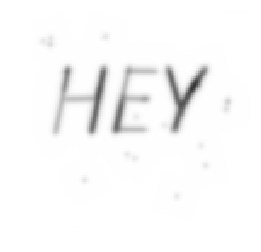

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.73it/s]


Final loss :  15.021289825439453


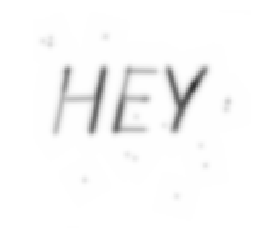

Drawing line number 47
Initializing the line..
Current best line initialization loss:  16.06093406677246
Current best line initialization loss:  15.920244216918945
Current best line initialization loss:  15.604706764221191
Current best line initialization loss:  15.458423614501953
Current best line initialization loss:  15.05649185180664


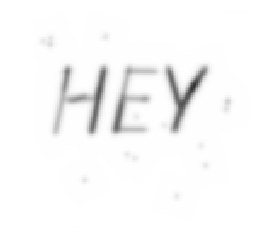

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.86it/s]


Final loss :  14.901570320129395


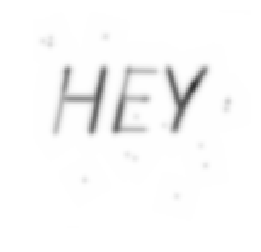

Drawing line number 48
Initializing the line..
Current best line initialization loss:  15.327970504760742
Current best line initialization loss:  15.168573379516602
Current best line initialization loss:  15.158905029296875
Current best line initialization loss:  15.103900909423828
Current best line initialization loss:  15.049118995666504
Current best line initialization loss:  15.005082130432129


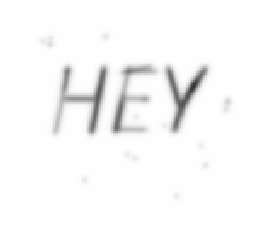

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.98it/s]


Final loss :  14.961289405822754


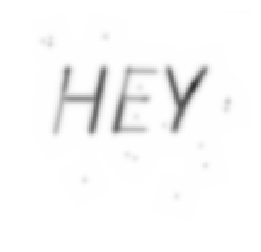

Drawing line number 49
Initializing the line..
Current best line initialization loss:  15.501201629638672
Current best line initialization loss:  15.376531600952148
Current best line initialization loss:  15.301532745361328
Current best line initialization loss:  15.104877471923828
Current best line initialization loss:  15.035658836364746


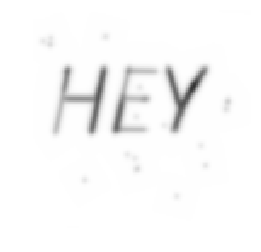

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.30it/s]


Final loss :  14.964261054992676


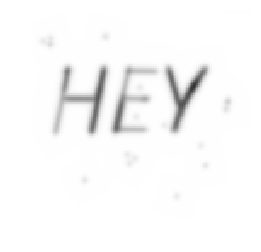

Drawing line number 50
Initializing the line..
Current best line initialization loss:  15.51209831237793
Current best line initialization loss:  15.431288719177246
Current best line initialization loss:  15.26890754699707
Current best line initialization loss:  15.241968154907227
Current best line initialization loss:  15.071044921875


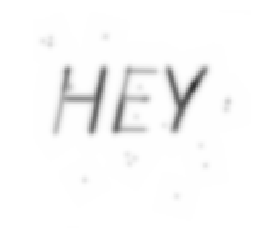

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.95it/s]


Final loss :  14.689335823059082


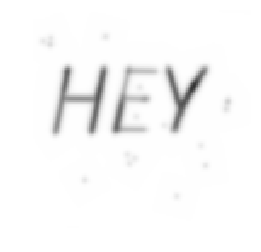

Drawing line number 51
Initializing the line..
Current best line initialization loss:  15.469686508178711
Current best line initialization loss:  15.103570938110352
Current best line initialization loss:  15.09300422668457
Current best line initialization loss:  15.081233978271484
Current best line initialization loss:  14.955348014831543
Current best line initialization loss:  14.68347454071045


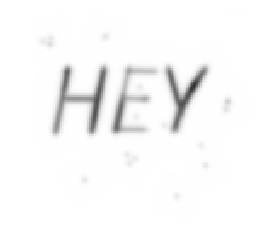

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.35it/s]


Final loss :  14.632976531982422


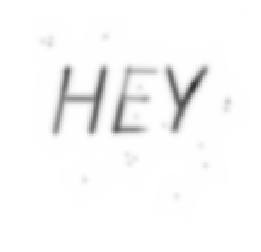

Drawing line number 52
Initializing the line..
Current best line initialization loss:  14.799041748046875
Current best line initialization loss:  14.740341186523438


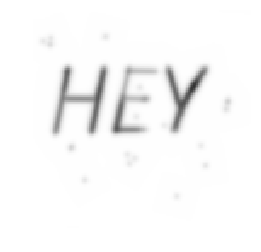

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.72it/s]


Final loss :  14.701652526855469


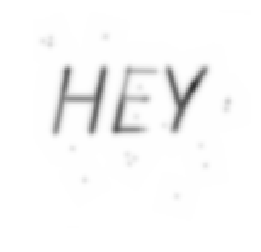

Drawing line number 53
Initializing the line..
Current best line initialization loss:  15.002006530761719
Current best line initialization loss:  14.874798774719238


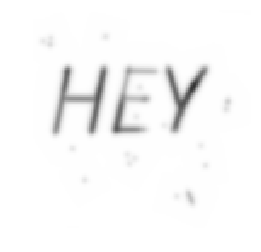

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.44it/s]


Final loss :  14.699892044067383


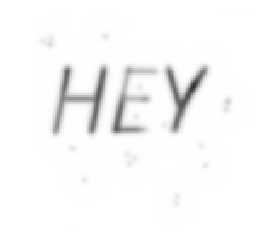

Drawing line number 54
Initializing the line..


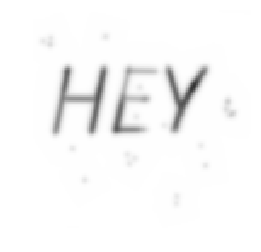

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.18it/s]


Final loss :  14.70849895477295


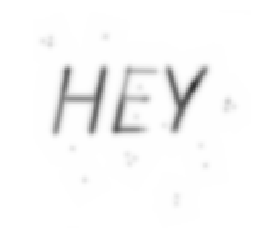

Drawing line number 55
Initializing the line..
Current best line initialization loss:  15.046802520751953
Current best line initialization loss:  14.978689193725586
Current best line initialization loss:  14.938944816589355
Current best line initialization loss:  14.895645141601562
Current best line initialization loss:  14.70605182647705


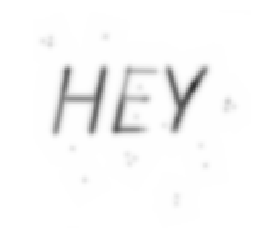

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.43it/s]


Final loss :  14.648332595825195


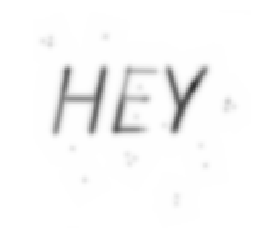

Drawing line number 56
Initializing the line..
Current best line initialization loss:  15.17847728729248
Current best line initialization loss:  15.021669387817383
Current best line initialization loss:  14.974651336669922
Current best line initialization loss:  14.875272750854492
Current best line initialization loss:  14.711915969848633


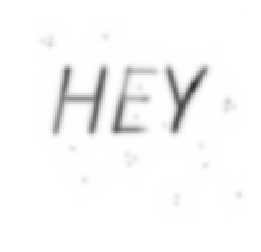

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 38.67it/s]


Final loss :  14.638647079467773


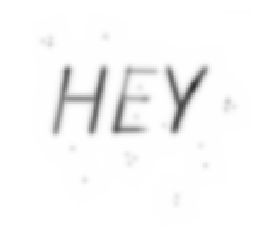

Drawing line number 57
Initializing the line..
Current best line initialization loss:  15.25636100769043
Current best line initialization loss:  15.046161651611328
Current best line initialization loss:  14.93506908416748
Current best line initialization loss:  14.847576141357422
Current best line initialization loss:  14.836669921875
Current best line initialization loss:  14.8273344039917
Current best line initialization loss:  14.720592498779297


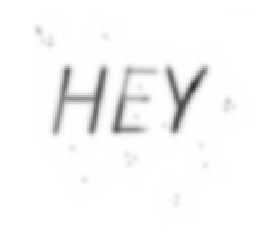

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.87it/s]


Final loss :  14.638647079467773


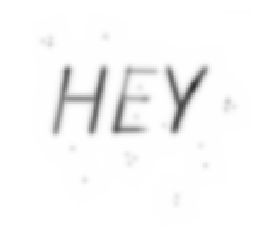

Drawing line number 58
Initializing the line..
Current best line initialization loss:  14.90052604675293
Current best line initialization loss:  14.613216400146484


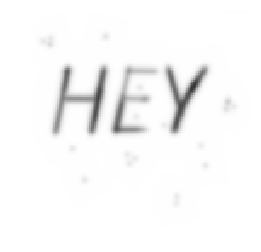

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.80it/s]


Final loss :  14.57967758178711


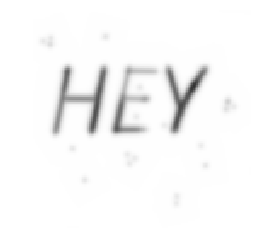

Drawing line number 59
Initializing the line..
Current best line initialization loss:  14.918039321899414
Current best line initialization loss:  14.916145324707031
Current best line initialization loss:  14.859870910644531
Current best line initialization loss:  14.760886192321777
Current best line initialization loss:  14.678485870361328


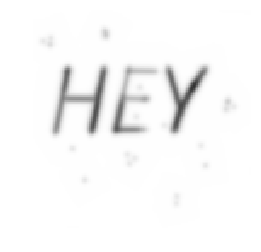

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.22it/s]


Final loss :  14.597501754760742


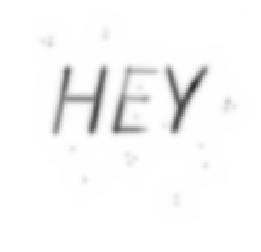

Drawing line number 60
Initializing the line..
Current best line initialization loss:  15.265869140625
Current best line initialization loss:  15.117070198059082
Current best line initialization loss:  15.069772720336914
Current best line initialization loss:  14.926658630371094
Current best line initialization loss:  14.814870834350586
Current best line initialization loss:  14.767126083374023
Current best line initialization loss:  14.554635047912598


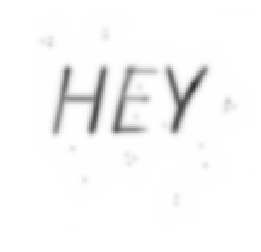

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.65it/s]


Final loss :  14.466899871826172


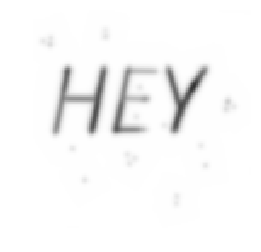

Drawing line number 61
Initializing the line..
Current best line initialization loss:  14.943440437316895
Current best line initialization loss:  14.749430656433105
Current best line initialization loss:  14.61988639831543
Current best line initialization loss:  14.547933578491211


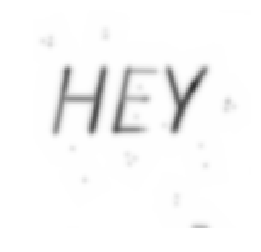

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.87it/s]


Final loss :  14.465550422668457


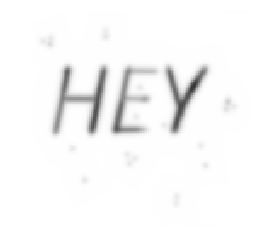

Drawing line number 62
Initializing the line..
Current best line initialization loss:  15.275156021118164
Current best line initialization loss:  14.923397064208984
Current best line initialization loss:  14.56673812866211


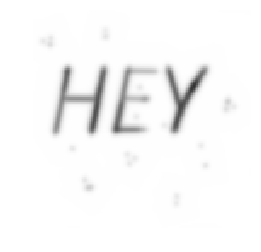

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.43it/s]


Final loss :  14.484248161315918


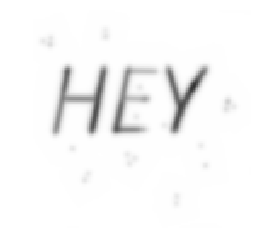

Drawing line number 63
Initializing the line..
Current best line initialization loss:  15.531668663024902
Current best line initialization loss:  14.56170654296875


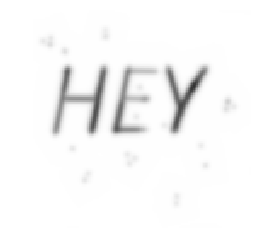

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.73it/s]


Final loss :  14.495408058166504


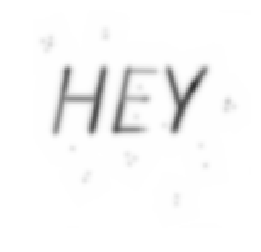

Drawing line number 64
Initializing the line..
Current best line initialization loss:  14.684309959411621
Current best line initialization loss:  14.635412216186523
Current best line initialization loss:  14.56571102142334


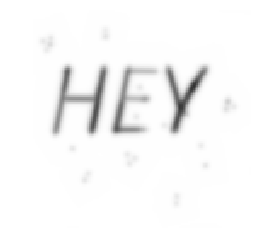

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.84it/s]


Final loss :  14.472551345825195


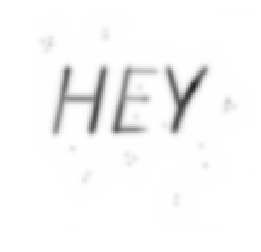

Drawing line number 65
Initializing the line..
Current best line initialization loss:  14.916950225830078
Current best line initialization loss:  14.862007141113281
Current best line initialization loss:  14.717374801635742
Current best line initialization loss:  14.697673797607422
Current best line initialization loss:  14.638809204101562
Current best line initialization loss:  14.616921424865723
Current best line initialization loss:  14.558037757873535


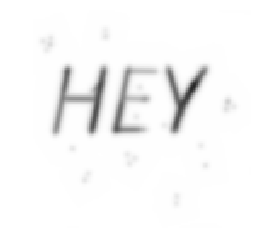

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.43it/s]


Final loss :  14.386812210083008


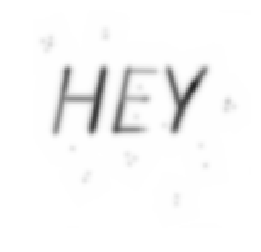

Drawing line number 66
Initializing the line..
Current best line initialization loss:  15.85525131225586
Current best line initialization loss:  15.204998016357422
Current best line initialization loss:  15.156625747680664
Current best line initialization loss:  14.91771411895752
Current best line initialization loss:  14.49730110168457


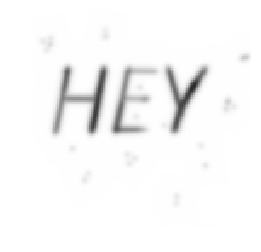

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.30it/s]


Final loss :  14.37797737121582


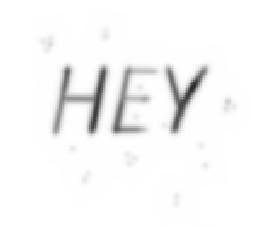

Drawing line number 67
Initializing the line..
Current best line initialization loss:  15.29505729675293
Current best line initialization loss:  14.806360244750977
Current best line initialization loss:  14.656744956970215
Current best line initialization loss:  14.593814849853516
Current best line initialization loss:  14.55248737335205
Current best line initialization loss:  14.48653793334961


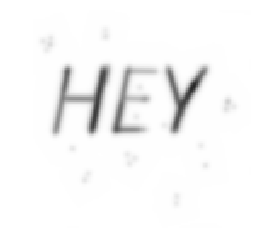

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.09it/s]


Final loss :  14.37744140625


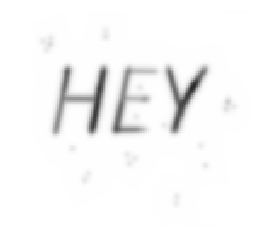

Drawing line number 68
Initializing the line..
Current best line initialization loss:  14.793024063110352
Current best line initialization loss:  14.66282844543457
Current best line initialization loss:  14.565725326538086
Current best line initialization loss:  14.467958450317383
Current best line initialization loss:  14.455141067504883


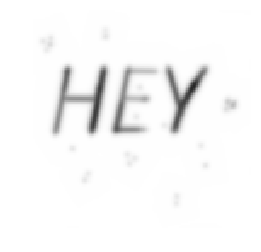

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.44it/s]


Final loss :  14.383617401123047


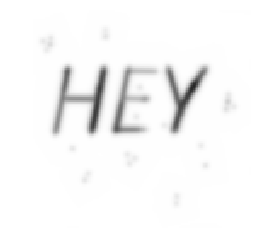

Drawing line number 69
Initializing the line..
Current best line initialization loss:  15.741690635681152
Current best line initialization loss:  15.16459846496582
Current best line initialization loss:  14.994585037231445
Current best line initialization loss:  14.974077224731445
Current best line initialization loss:  14.810752868652344
Current best line initialization loss:  14.493324279785156


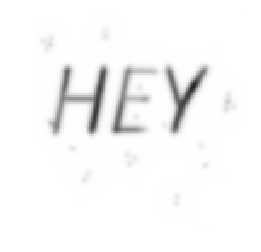

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.18it/s]


Final loss :  14.231999397277832


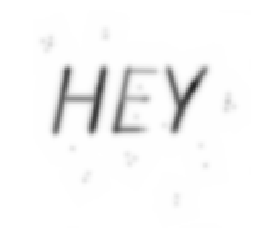

Drawing line number 70
Initializing the line..
Current best line initialization loss:  14.678147315979004
Current best line initialization loss:  14.642179489135742
Current best line initialization loss:  14.52147102355957
Current best line initialization loss:  14.28310775756836


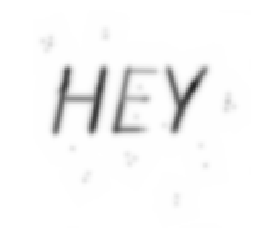

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.07it/s]


Final loss :  14.156100273132324


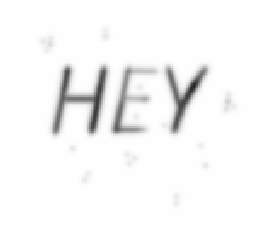

Drawing line number 71
Initializing the line..
Current best line initialization loss:  15.188846588134766
Current best line initialization loss:  14.7732572555542
Current best line initialization loss:  14.750500679016113
Current best line initialization loss:  14.416580200195312
Current best line initialization loss:  14.401126861572266
Current best line initialization loss:  14.395102500915527
Current best line initialization loss:  14.300106048583984
Current best line initialization loss:  14.288549423217773
Current best line initialization loss:  14.210562705993652


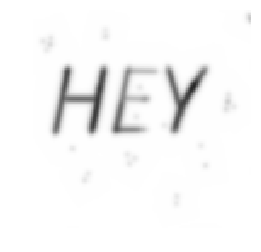

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 37.94it/s]


Final loss :  14.155525207519531


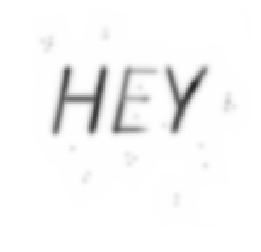

Drawing line number 72
Initializing the line..
Current best line initialization loss:  14.40244197845459
Current best line initialization loss:  14.197864532470703
Current best line initialization loss:  14.197433471679688


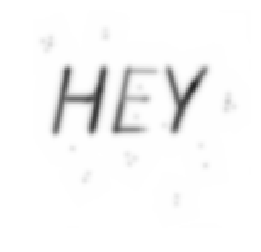

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.55it/s]


Final loss :  14.107134819030762


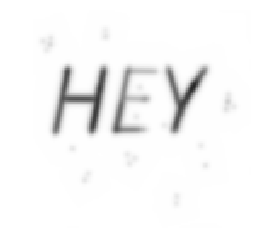

Drawing line number 73
Initializing the line..
Current best line initialization loss:  14.45301628112793
Current best line initialization loss:  14.29006290435791
Current best line initialization loss:  14.176108360290527


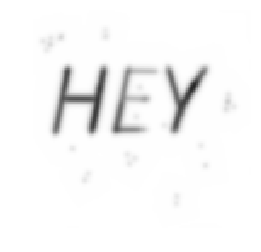

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.83it/s]


Final loss :  14.124446868896484


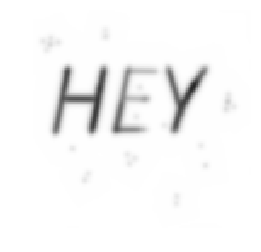

Drawing line number 74
Initializing the line..
Current best line initialization loss:  14.74957275390625
Current best line initialization loss:  14.459111213684082
Current best line initialization loss:  14.327376365661621
Current best line initialization loss:  14.147241592407227


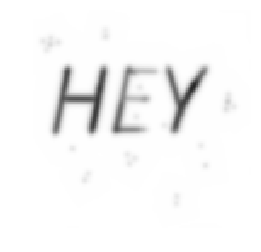

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.31it/s]


Final loss :  14.122241973876953


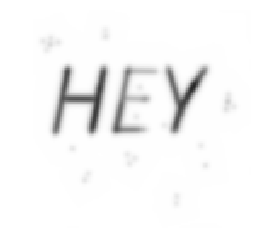

Drawing line number 75
Initializing the line..
Current best line initialization loss:  15.050775527954102
Current best line initialization loss:  14.799515724182129
Current best line initialization loss:  14.213650703430176


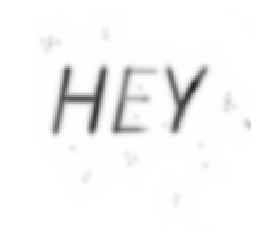

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.32it/s]


Final loss :  14.122200012207031


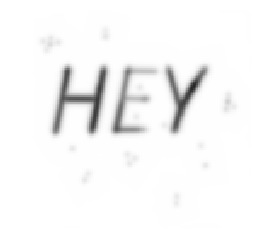

Drawing line number 76
Initializing the line..
Current best line initialization loss:  14.9698486328125
Current best line initialization loss:  14.876029968261719
Current best line initialization loss:  14.570443153381348
Current best line initialization loss:  14.540658950805664
Current best line initialization loss:  14.442625045776367
Current best line initialization loss:  14.416301727294922
Current best line initialization loss:  14.412200927734375
Current best line initialization loss:  14.274691581726074
Current best line initialization loss:  14.229063034057617
Current best line initialization loss:  14.228754997253418


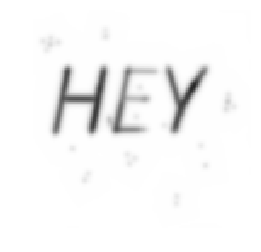

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.04it/s]


Final loss :  14.084113121032715


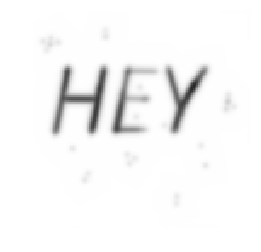

Drawing line number 77
Initializing the line..
Current best line initialization loss:  14.407764434814453
Current best line initialization loss:  14.292957305908203
Current best line initialization loss:  14.201303482055664
Current best line initialization loss:  14.187470436096191


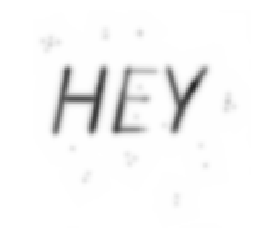

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.35it/s]


Final loss :  14.146167755126953


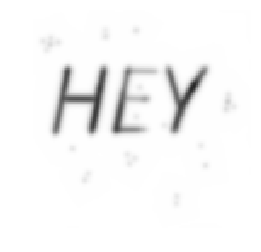

Drawing line number 78
Initializing the line..
Current best line initialization loss:  14.586746215820312
Current best line initialization loss:  14.501070022583008
Current best line initialization loss:  14.16106128692627


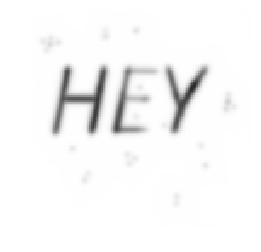

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.47it/s]


Final loss :  14.084123611450195


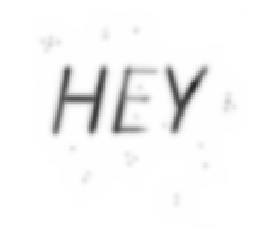

Drawing line number 79
Initializing the line..
Current best line initialization loss:  14.637123107910156
Current best line initialization loss:  14.599398612976074
Current best line initialization loss:  14.542572021484375
Current best line initialization loss:  14.189577102661133


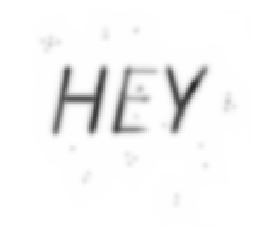

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.00it/s]


Final loss :  13.950580596923828


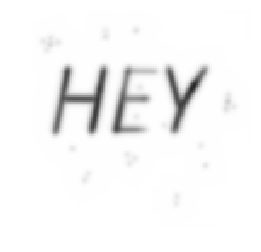

Drawing line number 80
Initializing the line..
Current best line initialization loss:  14.748396873474121
Current best line initialization loss:  14.54788589477539
Current best line initialization loss:  14.457315444946289
Current best line initialization loss:  14.457277297973633
Current best line initialization loss:  14.385669708251953
Current best line initialization loss:  14.37519359588623
Current best line initialization loss:  14.179583549499512
Current best line initialization loss:  13.973243713378906


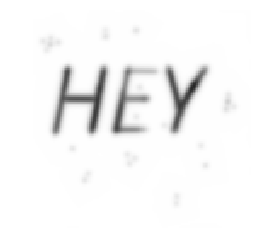

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.47it/s]


Final loss :  13.927214622497559


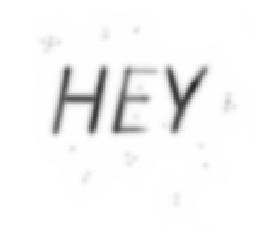

Drawing line number 81
Initializing the line..
Current best line initialization loss:  14.046839714050293


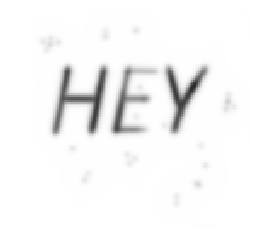

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.13it/s]


Final loss :  13.950315475463867


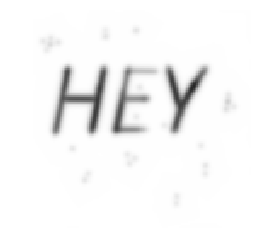

Drawing line number 82
Initializing the line..
Current best line initialization loss:  14.78219985961914
Current best line initialization loss:  14.517345428466797
Current best line initialization loss:  14.193023681640625
Current best line initialization loss:  14.186369895935059
Current best line initialization loss:  14.126649856567383
Current best line initialization loss:  14.122543334960938
Current best line initialization loss:  14.03034782409668


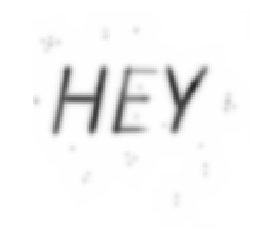

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.16it/s]


Final loss :  13.951096534729004


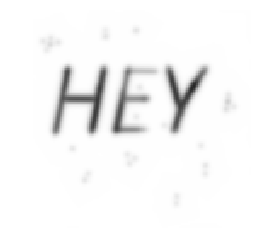

Drawing line number 83
Initializing the line..
Current best line initialization loss:  14.54017162322998
Current best line initialization loss:  14.220291137695312
Current best line initialization loss:  14.154932975769043
Current best line initialization loss:  13.977617263793945


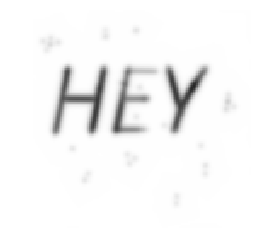

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.07it/s]


Final loss :  13.86751937866211


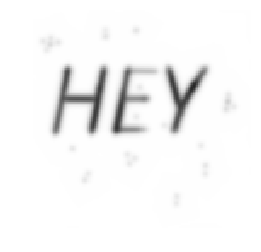

Drawing line number 84
Initializing the line..
Current best line initialization loss:  14.63486099243164
Current best line initialization loss:  14.591318130493164
Current best line initialization loss:  14.301233291625977
Current best line initialization loss:  14.231822967529297
Current best line initialization loss:  14.11724853515625
Current best line initialization loss:  14.101316452026367
Current best line initialization loss:  14.091399192810059
Current best line initialization loss:  13.915117263793945


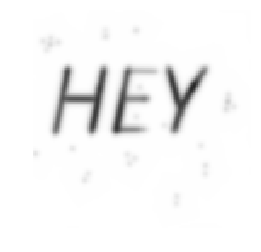

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.07it/s]


Final loss :  13.870214462280273


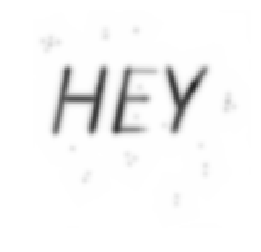

Drawing line number 85
Initializing the line..
Current best line initialization loss:  14.638593673706055
Current best line initialization loss:  14.245192527770996
Current best line initialization loss:  14.128815650939941
Current best line initialization loss:  14.073827743530273
Current best line initialization loss:  14.051841735839844
Current best line initialization loss:  14.0177640914917
Current best line initialization loss:  13.934331893920898


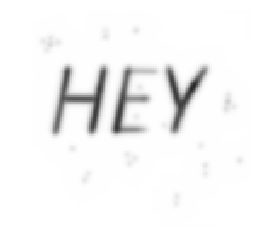

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.26it/s]


Final loss :  13.87021255493164


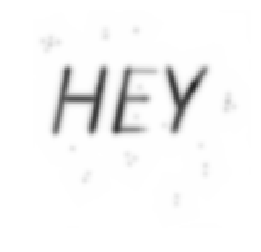

Drawing line number 86
Initializing the line..
Current best line initialization loss:  14.300474166870117
Current best line initialization loss:  14.287376403808594
Current best line initialization loss:  14.236745834350586
Current best line initialization loss:  14.117334365844727
Current best line initialization loss:  14.021049499511719
Current best line initialization loss:  13.948960304260254


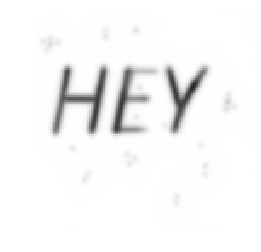

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.84it/s]


Final loss :  13.833755493164062


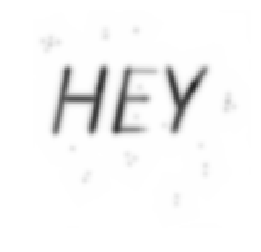

Drawing line number 87
Initializing the line..
Current best line initialization loss:  15.009342193603516
Current best line initialization loss:  14.802397727966309
Current best line initialization loss:  14.157644271850586
Current best line initialization loss:  14.083965301513672
Current best line initialization loss:  13.945489883422852
Current best line initialization loss:  13.927942276000977


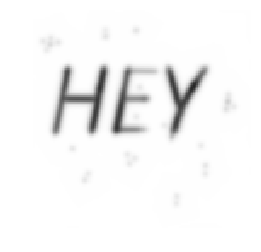

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.51it/s]


Final loss :  13.827850341796875


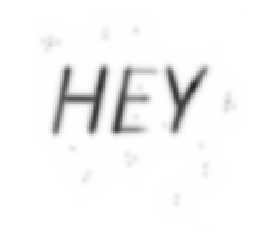

Drawing line number 88
Initializing the line..
Current best line initialization loss:  14.144970893859863
Current best line initialization loss:  14.127963066101074
Current best line initialization loss:  14.104449272155762
Current best line initialization loss:  13.947286605834961
Current best line initialization loss:  13.936100006103516
Current best line initialization loss:  13.933475494384766


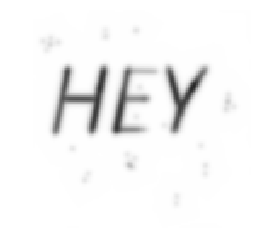

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.22it/s]


Final loss :  13.84057331085205


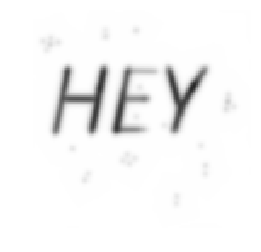

Drawing line number 89
Initializing the line..
Current best line initialization loss:  14.437224388122559
Current best line initialization loss:  14.327963829040527
Current best line initialization loss:  14.15042781829834
Current best line initialization loss:  14.060312271118164
Current best line initialization loss:  14.0508394241333
Current best line initialization loss:  13.986870765686035
Current best line initialization loss:  13.915840148925781


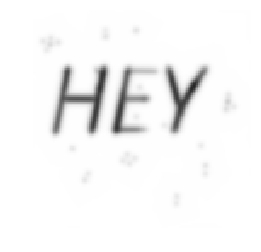

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.54it/s]


Final loss :  13.83580207824707


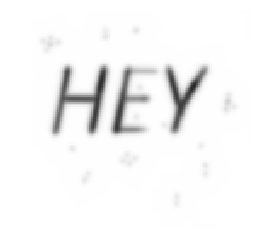

Drawing line number 90
Initializing the line..
Current best line initialization loss:  14.028306007385254
Current best line initialization loss:  13.977874755859375


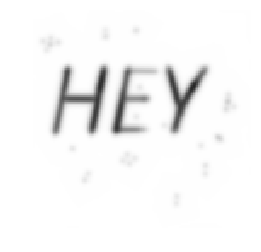

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.97it/s]


Final loss :  13.862955093383789


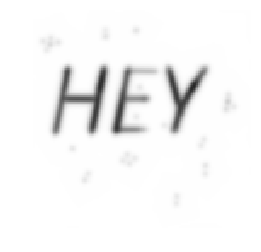

Drawing line number 91
Initializing the line..
Current best line initialization loss:  14.422454833984375
Current best line initialization loss:  14.279537200927734
Current best line initialization loss:  13.988325119018555
Current best line initialization loss:  13.906303405761719


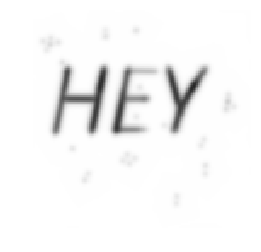

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.34it/s]


Final loss :  13.893672943115234


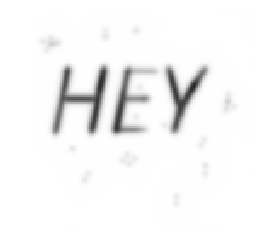

Drawing line number 92
Initializing the line..
Current best line initialization loss:  14.666128158569336
Current best line initialization loss:  14.300821304321289
Current best line initialization loss:  14.283740043640137
Current best line initialization loss:  14.230281829833984
Current best line initialization loss:  14.229168891906738
Current best line initialization loss:  13.976797103881836
Current best line initialization loss:  13.96693229675293


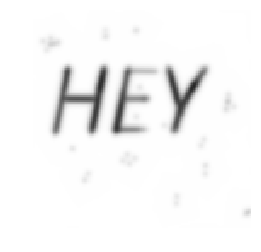

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.32it/s]


Final loss :  13.891860961914062


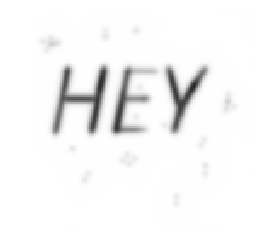

Drawing line number 93
Initializing the line..
Current best line initialization loss:  14.215904235839844
Current best line initialization loss:  14.033524513244629
Current best line initialization loss:  13.985713958740234


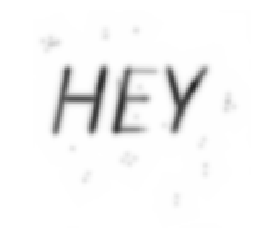

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.84it/s]


Final loss :  13.854809761047363


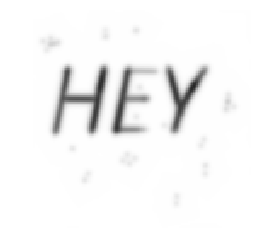

Drawing line number 94
Initializing the line..
Current best line initialization loss:  14.69350528717041
Current best line initialization loss:  14.271347045898438
Current best line initialization loss:  14.191848754882812
Current best line initialization loss:  14.059568405151367
Current best line initialization loss:  13.955423355102539
Current best line initialization loss:  13.87809944152832


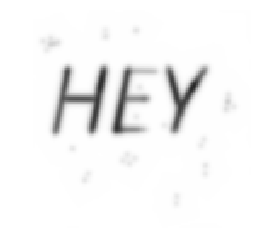

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.82it/s]


Final loss :  13.852819442749023


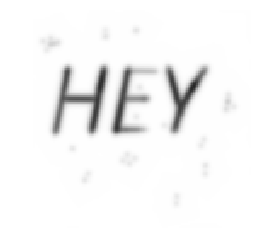

Drawing line number 95
Initializing the line..
Current best line initialization loss:  14.505949020385742
Current best line initialization loss:  14.3638277053833
Current best line initialization loss:  14.181283950805664
Current best line initialization loss:  14.082921028137207
Current best line initialization loss:  14.080671310424805
Current best line initialization loss:  14.06955623626709
Current best line initialization loss:  14.064361572265625


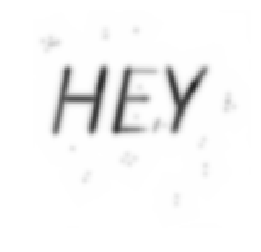

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 37.76it/s]


Final loss :  13.84457015991211


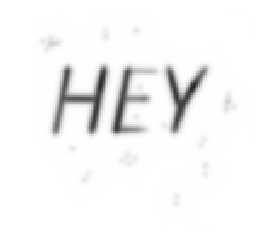

Drawing line number 96
Initializing the line..
Current best line initialization loss:  14.021775245666504
Current best line initialization loss:  13.9895601272583
Current best line initialization loss:  13.954338073730469


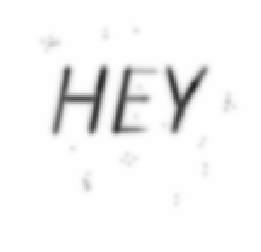

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 38.03it/s]


Final loss :  13.860811233520508


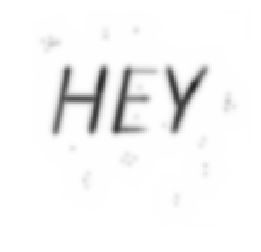

Drawing line number 97
Initializing the line..
Current best line initialization loss:  14.896462440490723
Current best line initialization loss:  14.556357383728027
Current best line initialization loss:  14.343814849853516
Current best line initialization loss:  14.183621406555176
Current best line initialization loss:  14.157180786132812
Current best line initialization loss:  14.092890739440918
Current best line initialization loss:  13.999937057495117
Current best line initialization loss:  13.952326774597168
Current best line initialization loss:  13.87600326538086


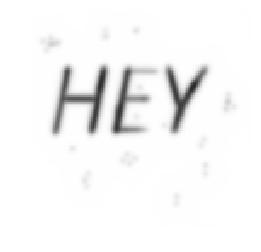

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 43.49it/s]


Final loss :  13.865218162536621


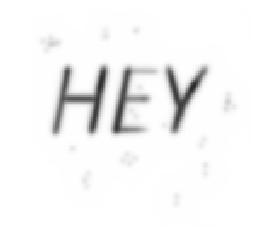

Drawing line number 98
Initializing the line..
Current best line initialization loss:  14.165779113769531
Current best line initialization loss:  14.113649368286133
Current best line initialization loss:  14.108753204345703
Current best line initialization loss:  14.078433990478516
Current best line initialization loss:  14.020339965820312
Current best line initialization loss:  13.933794021606445


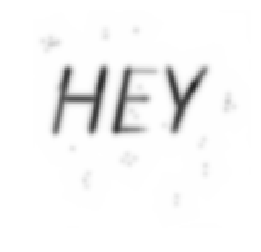

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 37.69it/s]


Final loss :  13.874643325805664


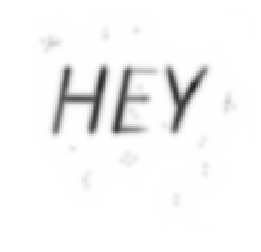

Drawing line number 99
Initializing the line..
Current best line initialization loss:  14.07693099975586
Current best line initialization loss:  14.056846618652344
Current best line initialization loss:  14.026716232299805
Current best line initialization loss:  13.944418907165527


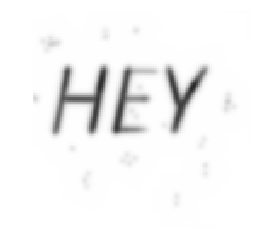

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.63it/s]


Final loss :  13.874551773071289


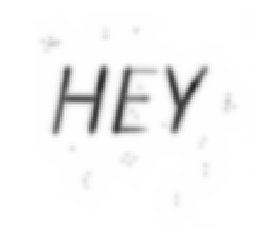

Drawing line number 100
Initializing the line..
Current best line initialization loss:  14.969619750976562
Current best line initialization loss:  14.704414367675781
Current best line initialization loss:  14.099641799926758
Current best line initialization loss:  14.059181213378906
Current best line initialization loss:  13.943130493164062


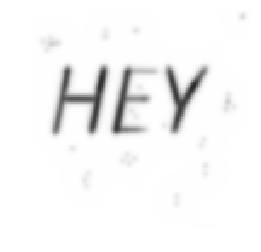

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.83it/s]


Final loss :  13.874551773071289


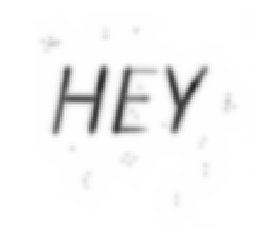

Drawing line number 101
Initializing the line..
Current best line initialization loss:  15.06482219696045
Current best line initialization loss:  14.647586822509766
Current best line initialization loss:  14.521268844604492
Current best line initialization loss:  14.239336013793945
Current best line initialization loss:  13.870074272155762


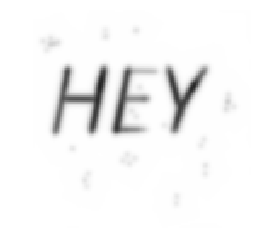

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.76it/s]


Final loss :  13.85511302947998


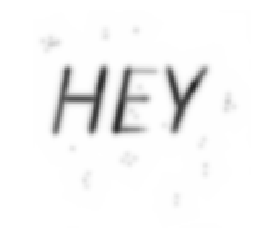

Drawing line number 102
Initializing the line..
Current best line initialization loss:  13.92428970336914
Current best line initialization loss:  13.896122932434082
Current best line initialization loss:  13.874797821044922


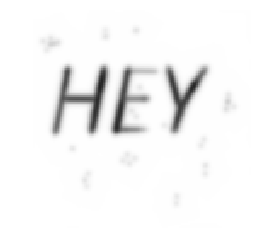

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 40.33it/s]


Final loss :  13.805143356323242


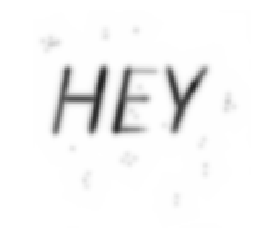

Drawing line number 103
Initializing the line..
Current best line initialization loss:  14.61545181274414
Current best line initialization loss:  14.22276782989502
Current best line initialization loss:  14.106220245361328
Current best line initialization loss:  13.996550559997559
Current best line initialization loss:  13.970977783203125
Current best line initialization loss:  13.961111068725586
Current best line initialization loss:  13.939379692077637
Current best line initialization loss:  13.874868392944336


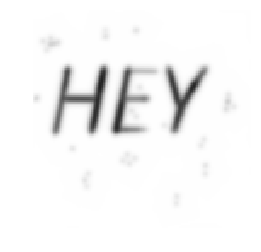

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.82it/s]


Final loss :  13.80565071105957


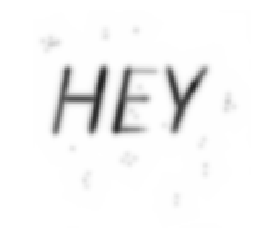

Drawing line number 104
Initializing the line..
Current best line initialization loss:  14.374092102050781
Current best line initialization loss:  14.07657241821289
Current best line initialization loss:  14.05018138885498
Current best line initialization loss:  13.979711532592773
Current best line initialization loss:  13.939031600952148
Current best line initialization loss:  13.866547584533691
Current best line initialization loss:  13.824771881103516


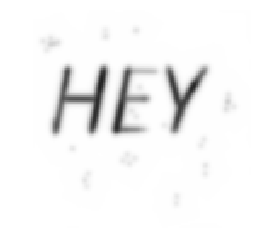

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.30it/s]


Final loss :  13.828933715820312


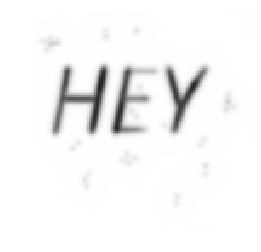

Drawing line number 105
Initializing the line..
Current best line initialization loss:  14.036407470703125
Current best line initialization loss:  13.977296829223633
Current best line initialization loss:  13.918021202087402


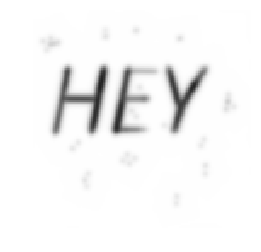

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.76it/s]


Final loss :  13.892391204833984


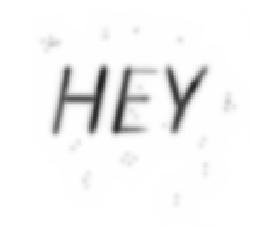

Drawing line number 106
Initializing the line..
Current best line initialization loss:  14.51620864868164
Current best line initialization loss:  14.266613006591797
Current best line initialization loss:  14.164338111877441
Current best line initialization loss:  14.13546371459961
Current best line initialization loss:  14.110222816467285
Current best line initialization loss:  14.106460571289062
Current best line initialization loss:  14.07903003692627


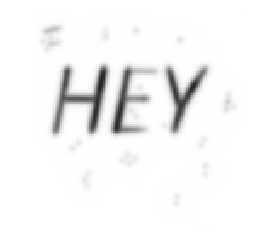

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.75it/s]


Final loss :  13.908126831054688


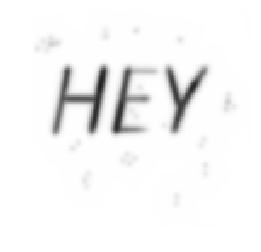

Drawing line number 107
Initializing the line..
Current best line initialization loss:  14.336383819580078
Current best line initialization loss:  14.273226737976074
Current best line initialization loss:  14.168478012084961
Current best line initialization loss:  14.054656028747559
Current best line initialization loss:  13.95673656463623


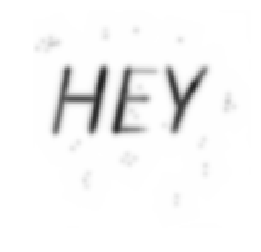

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.39it/s]


Final loss :  13.89100456237793


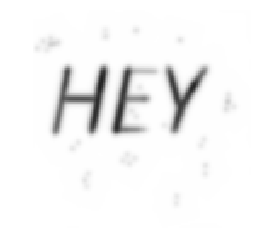

Drawing line number 108
Initializing the line..
Current best line initialization loss:  14.271060943603516
Current best line initialization loss:  13.99345588684082


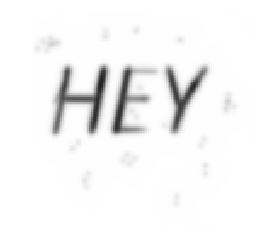

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.02it/s]


Final loss :  13.878823280334473


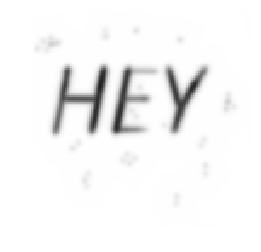

Drawing line number 109
Initializing the line..
Current best line initialization loss:  14.144405364990234
Current best line initialization loss:  14.051709175109863
Current best line initialization loss:  13.980486869812012


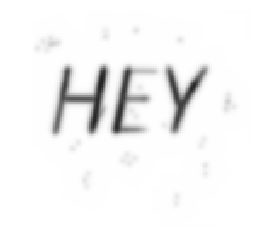

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 43.06it/s]


Final loss :  13.874700546264648


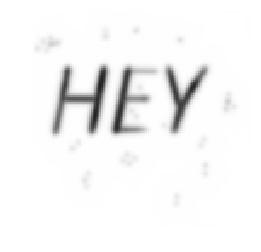

Drawing line number 110
Initializing the line..
Current best line initialization loss:  14.301419258117676
Current best line initialization loss:  14.266027450561523
Current best line initialization loss:  14.250694274902344
Current best line initialization loss:  14.12407398223877
Current best line initialization loss:  14.112754821777344
Current best line initialization loss:  14.092541694641113
Current best line initialization loss:  14.078878402709961
Current best line initialization loss:  13.99771499633789
Current best line initialization loss:  13.994224548339844
Current best line initialization loss:  13.960668563842773


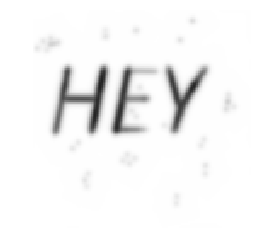

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 38.60it/s]


Final loss :  13.87458324432373


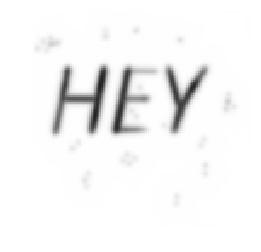

Drawing line number 111
Initializing the line..
Current best line initialization loss:  14.602252960205078
Current best line initialization loss:  14.451679229736328
Current best line initialization loss:  14.187883377075195
Current best line initialization loss:  14.137940406799316
Current best line initialization loss:  14.094398498535156
Current best line initialization loss:  14.054670333862305
Current best line initialization loss:  14.045501708984375


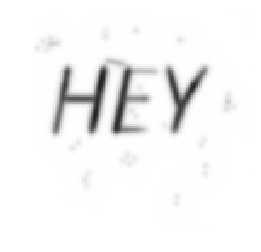

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.76it/s]


Final loss :  13.90334701538086


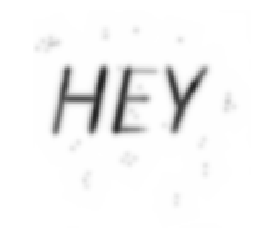

Drawing line number 112
Initializing the line..
Current best line initialization loss:  14.425884246826172
Current best line initialization loss:  14.422053337097168
Current best line initialization loss:  14.194313049316406
Current best line initialization loss:  14.157064437866211
Current best line initialization loss:  14.103260040283203
Current best line initialization loss:  14.08290958404541
Current best line initialization loss:  14.041518211364746
Current best line initialization loss:  14.015316009521484


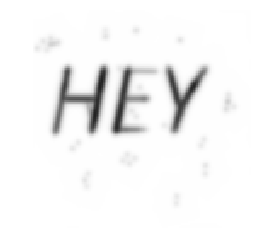

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.25it/s]


Final loss :  13.889726638793945


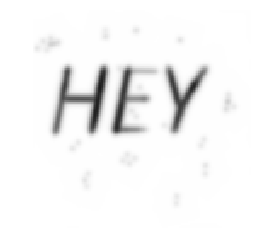

Drawing line number 113
Initializing the line..
Current best line initialization loss:  14.811150550842285
Current best line initialization loss:  14.222393035888672
Current best line initialization loss:  14.213288307189941
Current best line initialization loss:  13.891979217529297


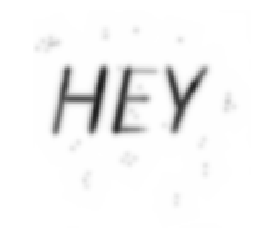

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.72it/s]


Final loss :  13.822863578796387


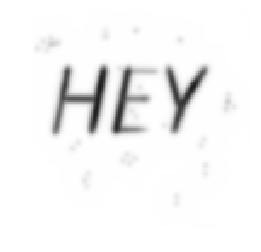

Drawing line number 114
Initializing the line..
Current best line initialization loss:  14.050430297851562
Current best line initialization loss:  13.94340991973877
Current best line initialization loss:  13.85311508178711


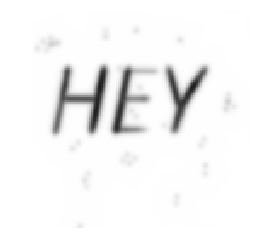

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.73it/s]


Final loss :  13.821609497070312


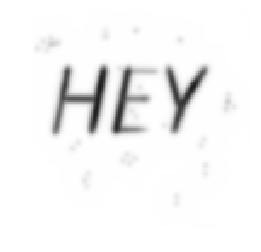

Drawing line number 115
Initializing the line..
Current best line initialization loss:  14.409961700439453
Current best line initialization loss:  14.118087768554688
Current best line initialization loss:  14.062406539916992
Current best line initialization loss:  14.04697036743164
Current best line initialization loss:  13.99877643585205
Current best line initialization loss:  13.992172241210938
Current best line initialization loss:  13.972280502319336
Current best line initialization loss:  13.941671371459961


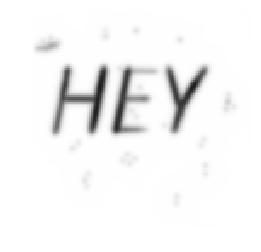

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.83it/s]


Final loss :  13.821608543395996


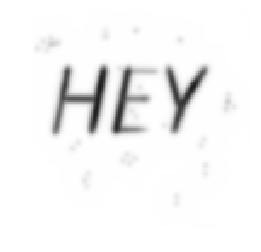

Drawing line number 116
Initializing the line..
Current best line initialization loss:  14.054502487182617
Current best line initialization loss:  13.974302291870117
Current best line initialization loss:  13.909164428710938
Current best line initialization loss:  13.881692886352539


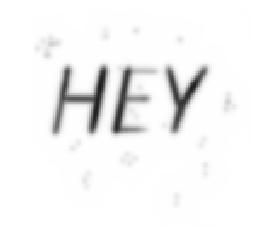

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.71it/s]


Final loss :  13.821634292602539


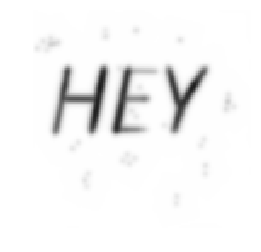

Drawing line number 117
Initializing the line..
Current best line initialization loss:  14.632233619689941
Current best line initialization loss:  14.415824890136719
Current best line initialization loss:  14.254920959472656
Current best line initialization loss:  14.105508804321289
Current best line initialization loss:  14.031168937683105
Current best line initialization loss:  13.995392799377441
Current best line initialization loss:  13.958234786987305


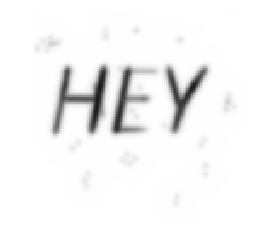

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.40it/s]


Final loss :  13.821227073669434


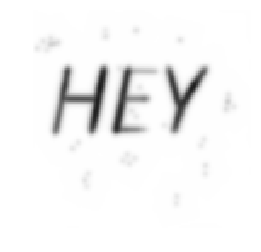

Drawing line number 118
Initializing the line..
Current best line initialization loss:  14.144477844238281
Current best line initialization loss:  14.089212417602539
Current best line initialization loss:  14.073366165161133
Current best line initialization loss:  14.024800300598145
Current best line initialization loss:  14.017538070678711
Current best line initialization loss:  13.996722221374512
Current best line initialization loss:  13.97431755065918


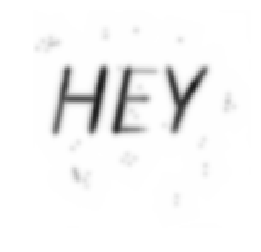

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.26it/s]


Final loss :  13.841829299926758


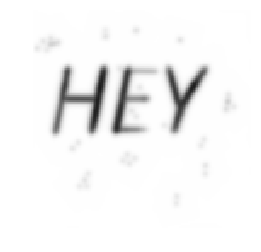

Drawing line number 119
Initializing the line..
Current best line initialization loss:  14.051990509033203
Current best line initialization loss:  13.889020919799805
Current best line initialization loss:  13.874602317810059


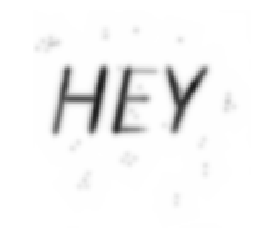

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.43it/s]


Final loss :  13.852478981018066


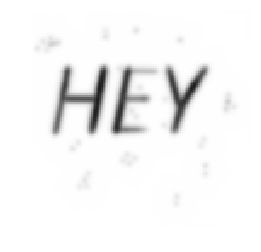

Drawing line number 120
Initializing the line..
Current best line initialization loss:  14.357412338256836
Current best line initialization loss:  14.075265884399414
Current best line initialization loss:  14.056981086730957
Current best line initialization loss:  14.004960060119629


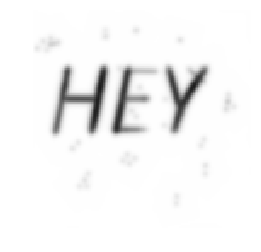

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 31.01it/s]


Final loss :  13.81298542022705


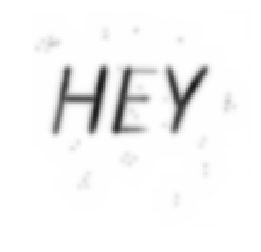

Drawing line number 121
Initializing the line..
Current best line initialization loss:  14.507584571838379
Current best line initialization loss:  14.477349281311035
Current best line initialization loss:  13.898773193359375


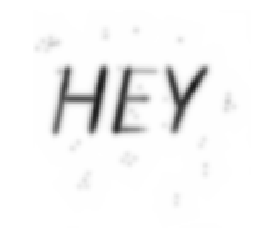

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 34.00it/s]


Final loss :  13.785933494567871


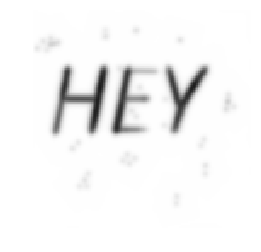

Drawing line number 122
Initializing the line..
Current best line initialization loss:  14.252864837646484
Current best line initialization loss:  14.116936683654785
Current best line initialization loss:  14.025062561035156
Current best line initialization loss:  13.88623332977295
Current best line initialization loss:  13.816305160522461


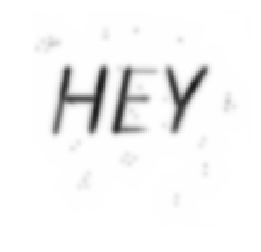

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 32.43it/s]


Final loss :  13.786602020263672


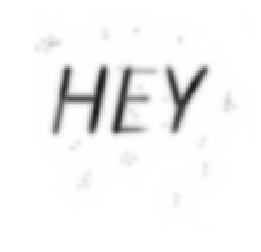

Drawing line number 123
Initializing the line..
Current best line initialization loss:  14.29659652709961
Current best line initialization loss:  14.052895545959473
Current best line initialization loss:  13.866270065307617
Current best line initialization loss:  13.861879348754883


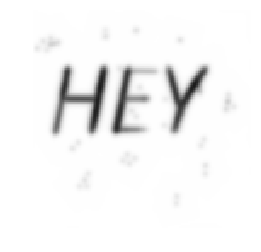

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.52it/s]


Final loss :  13.776890754699707


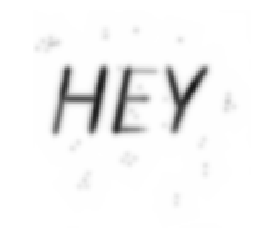

Drawing line number 124
Initializing the line..
Current best line initialization loss:  13.959234237670898
Current best line initialization loss:  13.926847457885742


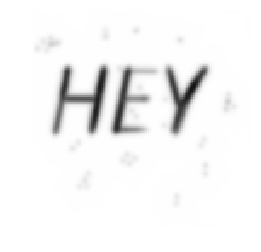

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 31.24it/s]


Final loss :  13.77785873413086


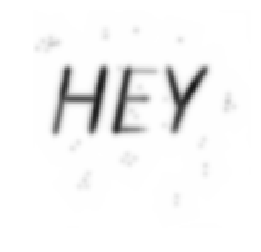

Drawing line number 125
Initializing the line..
Current best line initialization loss:  13.976320266723633
Current best line initialization loss:  13.913211822509766
Current best line initialization loss:  13.882956504821777
Current best line initialization loss:  13.818220138549805


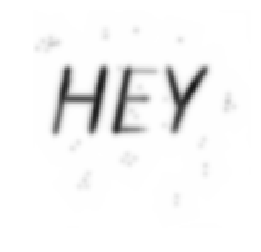

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 33.38it/s]


Final loss :  13.787038803100586


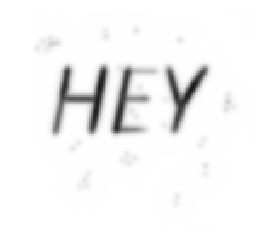

Drawing line number 126
Initializing the line..
Current best line initialization loss:  13.936944961547852
Current best line initialization loss:  13.910591125488281


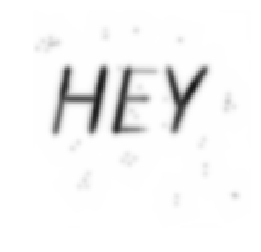

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 30.62it/s]


Final loss :  13.791728019714355


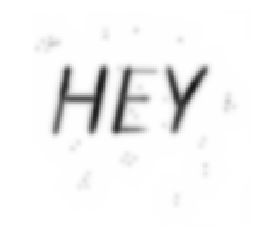

Drawing line number 127
Initializing the line..
Current best line initialization loss:  14.552148818969727
Current best line initialization loss:  14.42654800415039
Current best line initialization loss:  13.99272632598877
Current best line initialization loss:  13.92582893371582


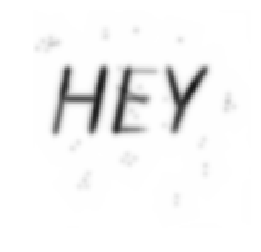

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.55it/s]


Final loss :  13.71186351776123


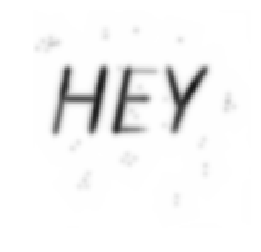

Drawing line number 128
Initializing the line..
Current best line initialization loss:  14.5628023147583
Current best line initialization loss:  14.202350616455078
Current best line initialization loss:  14.1649751663208
Current best line initialization loss:  13.960457801818848
Current best line initialization loss:  13.924160957336426
Current best line initialization loss:  13.870959281921387
Current best line initialization loss:  13.796370506286621
Current best line initialization loss:  13.775341987609863


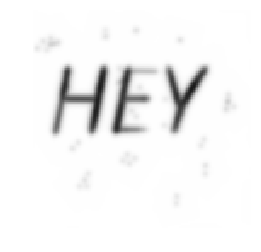

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 33.86it/s]


Final loss :  13.700238227844238


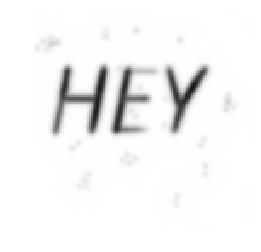

Drawing line number 129
Initializing the line..
Current best line initialization loss:  14.20681381225586
Current best line initialization loss:  14.066598892211914
Current best line initialization loss:  14.019330978393555
Current best line initialization loss:  13.874699592590332
Current best line initialization loss:  13.86895751953125


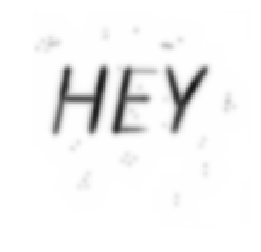

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.12it/s]


Final loss :  13.716836929321289


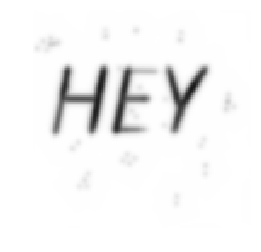

Drawing line number 130
Initializing the line..
Current best line initialization loss:  14.506977081298828
Current best line initialization loss:  14.115518569946289
Current best line initialization loss:  13.951250076293945
Current best line initialization loss:  13.941974639892578
Current best line initialization loss:  13.881001472473145


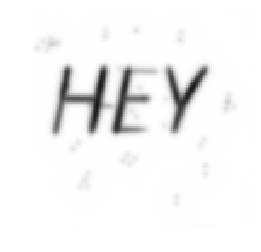

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 33.90it/s]


Final loss :  13.714113235473633


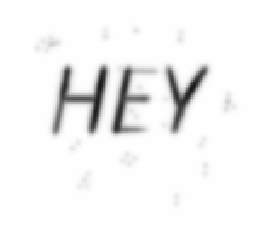

Drawing line number 131
Initializing the line..
Current best line initialization loss:  14.747313499450684
Current best line initialization loss:  13.958625793457031
Current best line initialization loss:  13.819841384887695
Current best line initialization loss:  13.795166969299316
Current best line initialization loss:  13.79347038269043
Current best line initialization loss:  13.778731346130371
Current best line initialization loss:  13.76933479309082


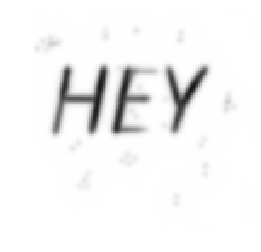

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 31.22it/s]


Final loss :  13.714859962463379


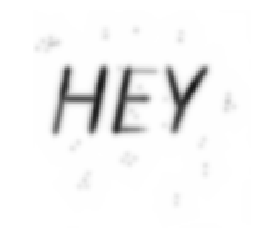

Drawing line number 132
Initializing the line..
Current best line initialization loss:  14.057689666748047
Current best line initialization loss:  14.04466724395752
Current best line initialization loss:  13.952089309692383
Current best line initialization loss:  13.861539840698242
Current best line initialization loss:  13.825621604919434
Current best line initialization loss:  13.784749984741211


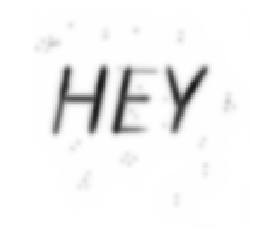

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.35it/s]


Final loss :  13.714641571044922


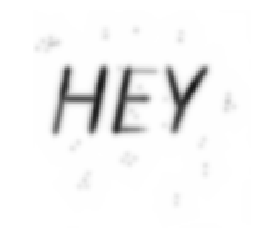

Drawing line number 133
Initializing the line..
Current best line initialization loss:  14.456841468811035
Current best line initialization loss:  14.080832481384277
Current best line initialization loss:  14.005779266357422
Current best line initialization loss:  13.958558082580566
Current best line initialization loss:  13.860383033752441
Current best line initialization loss:  13.796475410461426


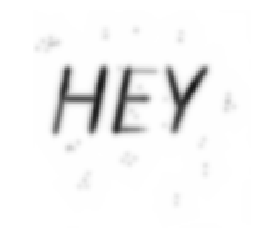

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 39.65it/s]


Final loss :  13.744544982910156


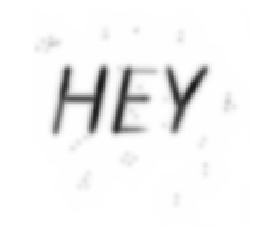

Drawing line number 134
Initializing the line..
Current best line initialization loss:  14.02135944366455
Current best line initialization loss:  13.960769653320312
Current best line initialization loss:  13.730380058288574


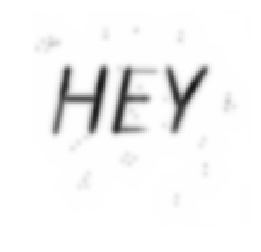

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.43it/s]


Final loss :  13.67573356628418


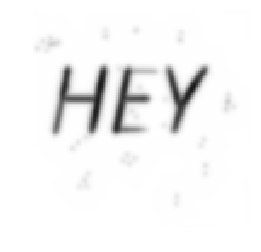

Drawing line number 135
Initializing the line..
Current best line initialization loss:  15.042932510375977
Current best line initialization loss:  14.466879844665527
Current best line initialization loss:  14.107481956481934
Current best line initialization loss:  13.844688415527344
Current best line initialization loss:  13.817657470703125
Current best line initialization loss:  13.792842864990234


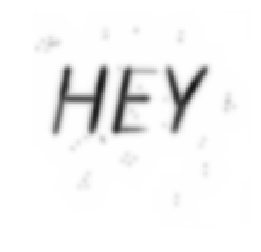

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 36.29it/s]


Final loss :  13.644010543823242


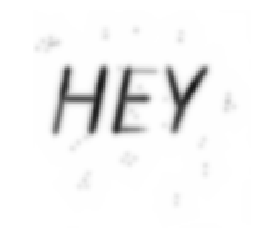

Drawing line number 136
Initializing the line..
Current best line initialization loss:  15.273551940917969
Current best line initialization loss:  14.404142379760742
Current best line initialization loss:  14.275749206542969
Current best line initialization loss:  14.21186637878418
Current best line initialization loss:  14.135337829589844
Current best line initialization loss:  13.851572036743164
Current best line initialization loss:  13.811058044433594
Current best line initialization loss:  13.683980941772461


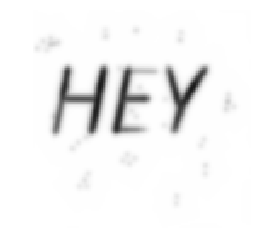

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 32.12it/s]


Final loss :  13.607551574707031


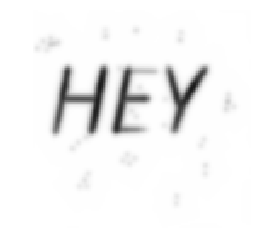

Drawing line number 137
Initializing the line..
Current best line initialization loss:  13.84808349609375
Current best line initialization loss:  13.762657165527344
Current best line initialization loss:  13.570390701293945


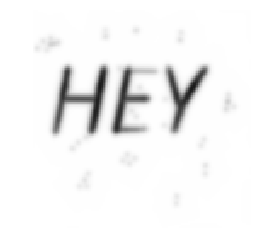

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.76it/s]


Final loss :  13.622730255126953


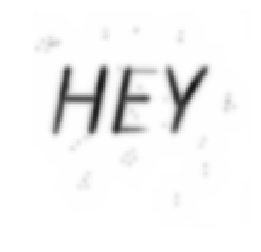

Drawing line number 138
Initializing the line..
Current best line initialization loss:  14.058945655822754
Current best line initialization loss:  13.916797637939453
Current best line initialization loss:  13.879554748535156
Current best line initialization loss:  13.834137916564941
Current best line initialization loss:  13.724909782409668


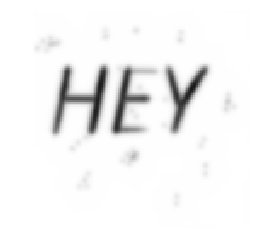

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 32.43it/s]


Final loss :  13.621488571166992


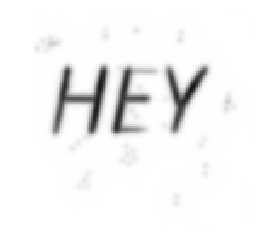

Drawing line number 139
Initializing the line..
Current best line initialization loss:  13.85285472869873
Current best line initialization loss:  13.796392440795898
Current best line initialization loss:  13.76491928100586


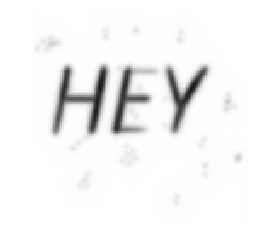

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 37.30it/s]


Final loss :  13.622274398803711


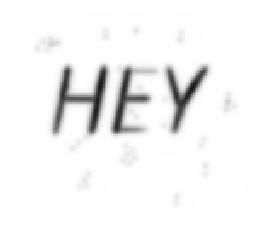

Drawing line number 140
Initializing the line..
Current best line initialization loss:  13.811589241027832
Current best line initialization loss:  13.648589134216309


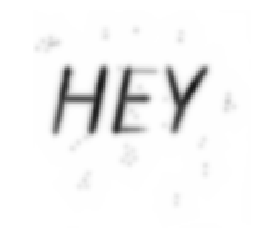

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 41.95it/s]


Final loss :  13.624269485473633


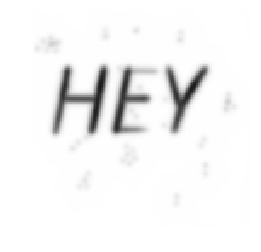

Drawing line number 141
Initializing the line..
Current best line initialization loss:  14.101301193237305
Current best line initialization loss:  14.095674514770508
Current best line initialization loss:  13.908584594726562
Current best line initialization loss:  13.834237098693848
Current best line initialization loss:  13.77411937713623
Current best line initialization loss:  13.6137113571167


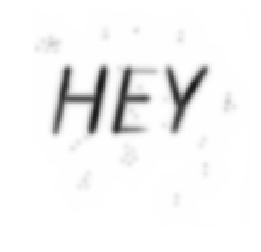

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 35.05it/s]


Final loss :  13.615768432617188


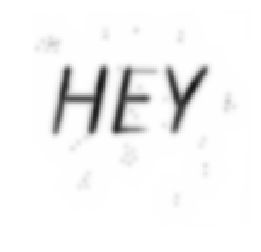

Drawing line number 142
Initializing the line..
Current best line initialization loss:  14.438752174377441
Current best line initialization loss:  13.946216583251953
Current best line initialization loss:  13.765679359436035
Current best line initialization loss:  13.722378730773926


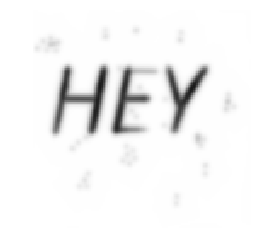

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.63it/s]


Final loss :  13.636240005493164


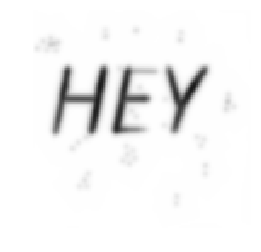

Drawing line number 143
Initializing the line..
Current best line initialization loss:  14.187835693359375
Current best line initialization loss:  14.031365394592285
Current best line initialization loss:  13.863377571105957
Current best line initialization loss:  13.836495399475098
Current best line initialization loss:  13.707019805908203
Current best line initialization loss:  13.692788124084473


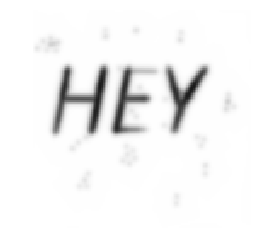

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 31.03it/s]


Final loss :  13.616525650024414


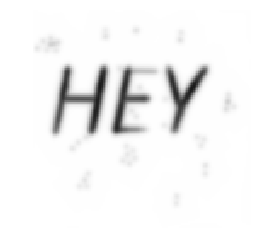

Drawing line number 144
Initializing the line..


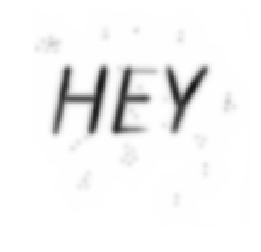

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 35.58it/s]


Final loss :  13.598323822021484


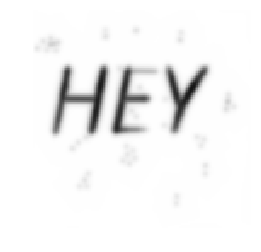

Drawing line number 145
Initializing the line..
Current best line initialization loss:  14.374788284301758
Current best line initialization loss:  14.034296989440918
Current best line initialization loss:  13.974246978759766
Current best line initialization loss:  13.824588775634766
Current best line initialization loss:  13.81300163269043
Current best line initialization loss:  13.744142532348633
Current best line initialization loss:  13.737197875976562


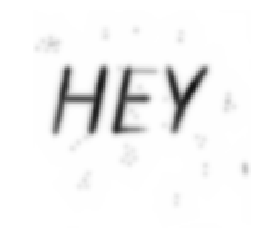

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 42.01it/s]


Final loss :  13.597633361816406


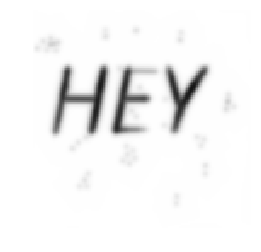

Drawing line number 146
Initializing the line..
Current best line initialization loss:  14.024693489074707
Current best line initialization loss:  13.79328727722168
Current best line initialization loss:  13.742103576660156


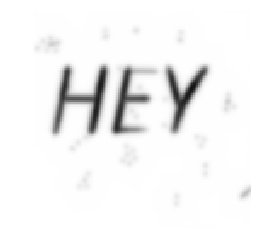

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 35.32it/s]


Final loss :  13.597634315490723


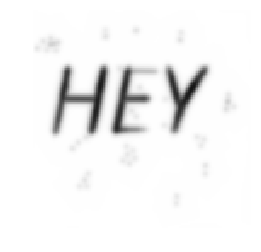

Drawing line number 147
Initializing the line..
Current best line initialization loss:  15.001181602478027
Current best line initialization loss:  14.120506286621094
Current best line initialization loss:  13.910402297973633
Current best line initialization loss:  13.889167785644531
Current best line initialization loss:  13.80517292022705
Current best line initialization loss:  13.639383316040039
Current best line initialization loss:  13.593777656555176


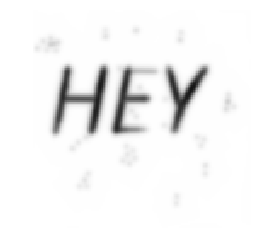

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.59it/s]


Final loss :  13.597633361816406


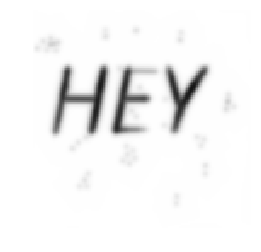

Drawing line number 148
Initializing the line..
Current best line initialization loss:  13.733933448791504
Current best line initialization loss:  13.709205627441406
Current best line initialization loss:  13.633952140808105


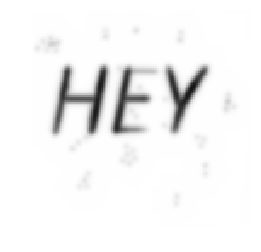

Optimizing the line..


100%|██████████| 40/40 [00:00<00:00, 40.67it/s]


Final loss :  13.593122482299805


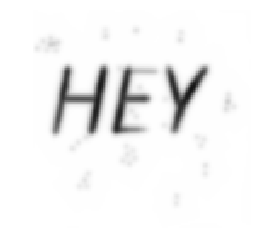

Drawing line number 149
Initializing the line..
Current best line initialization loss:  13.82312297821045
Current best line initialization loss:  13.69726276397705


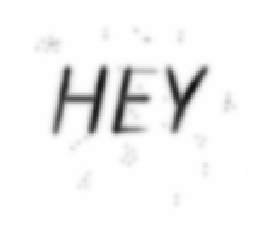

Optimizing the line..


100%|██████████| 40/40 [00:01<00:00, 37.33it/s]


Final loss :  13.619182586669922


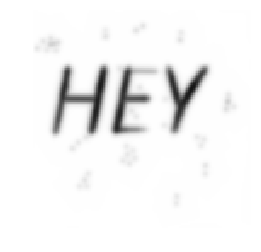

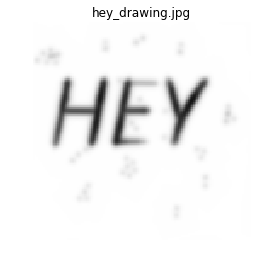

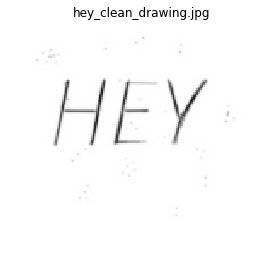

In [18]:
drawer = run(image_loader("./Images/texte.jpg"), 150, n_epochs, unblur=True, save=False, save_title='hey')

### Coloring monochrome surfaces

The Drawer also intuitively colors monochrome surfaces by adding multiple lines, just as we would do with a pencil. Here is an example of this behaviour on a target image:

In [ ]:
n_lines = 250

In [ ]:
imshow(image_loader("./Images/ovale plein.jpg"))

In [ ]:
drawer = run(image_loader("./Images/ovale plein.jpg"), n_lines, n_epochs, unblur=True, save=False, save_title='ovale plein')

<a id='section3'></a>

# Drawing simplified images

Before we try to draw complex images like real colored pictures, we first test the drawer on a simplified version of a picture of a boat. We feed it a black and white picture whose composed of straight lines only. Here is what it looks like:

In [ ]:
n_lines = 250

In [ ]:
imshow(image_loader("./Images/stickboat.jpg"))

In [ ]:
drawer = run(image_loader("./Images/stickboat.jpg"), n_lines, n_epochs, unblur=True, save=False, save_title='stickboat')

<a id='section4'></a>

# Drawing complex images

In [ ]:
imshow(image_loader("./Images/boat.jpg"))

In [ ]:
drawer = run(image_loader("./Images/boat.jpg"), n_lines, n_epochs, unblur=True, save=False, save_title='boat')

<a id='section5'></a>

# Drawing images imported by the user

In this section you can choose to have ARIES draw either: 
- an image that is saved locally on your computer by filling the variable img_path with the path to your image
or
- an image you found on the internet but didn't download yet by filling img_url with the url of your image

In [ ]:
img_url = ''
img_path = ''

In [ ]:
if img_url != '':
    urllib.request.urlretrieve(img_url, "./target_img.png")
    img_path = "./target_img.png"
# this cell downloads an image if you specified any url in img_url

The target image:

In [ ]:
imshow(image_loader(img_path))

The drawing:

In [ ]:
drawer = run(image_loader(img_path), n_lines, n_epochs, unblur=True, save=False, save_title='')